## Aim

This notebook could help keep tracking of the quality for all the input data for upset models and help generate data quality report.

## Importing libraries

Defining important variables and importing required libraries 

In [740]:
# All the libraries to be imported are defined here
from datetime import datetime
import numpy as np
import pandas as pd
import pickle
import json
import os
import copy
import sys

from sklearn.metrics import roc_auc_score, precision_recall_curve, average_precision_score
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.base import clone

from matplotlib import pyplot as plt
from IPython.display import Markdown
import seaborn as sns

from matplotlib import pyplot as plt
from bokeh.io import output_file, show, output_notebook, push_notebook
from bokeh.layouts import gridplot
from bokeh.models import ColumnDataSource, HoverTool
from bokeh.transform import factor_cmap 
from bokeh.palettes import viridis
from bokeh.palettes import Set1
from bokeh.plotting import figure, show, output_notebook, save, output_file

import ipywidgets as widgets
from ipywidgets import Button, Layout, Label, interact
from IPython.display import display
from bokeh.io import export_png
from bokeh.embed import file_html
from bokeh.resources import CDN

## output all figures generated to this notebook
output_notebook()

Loading BokehJS ...

In [741]:
# Shows plots in jupyter notebook
%matplotlib inline
# Set plot style
sns.set(color_codes=True)

In [742]:
sys.path.append('C:/Users/XiaoShuoCui/Documents/GitHub/suncor/upset_flagging/')

## Prepare Function

In [752]:
def visual_yearly_missing(data, model, year, path):
    '''
    This function sum and visualize the missing data situation for a specific model
    Input:
            data: df
    Output: 
            The graph
          
    '''
    import bokeh.io
    from bokeh.io import show
    from bokeh.plotting import figure
    from bokeh.models import ColumnDataSource, HoverTool
    from bokeh.transform import factor_cmap
    
# ----------------------------------------------------------------------------------
    # Preprocessing
    # Save the total number of missing in df_miss_count
    df_miss_count = pd.DataFrame(df.isna().sum().values, columns=['missing_count'])
    df_miss_count['tag_name'] = df.isna().sum().index

    # Add column stating the percentage of missing
    df_miss_count['per_missing'] = (df_miss_count['missing_count']/df.shape[0]).round(2)
    
    # Sort the df
    df_miss_count.sort_values(by = ['missing_count'], ascending = False, inplace=True)

    # Make copy of the data
    data_copy = df_miss_count.copy()
    
    
# ----------------------------------------------------------------------------------    
    # Plot
    # Create group object and source data
#     group = data_copy.groupby(by=['tag_name'])
    source = ColumnDataSource(data_copy)

    # prepare figure
    p = figure(plot_width=1500, plot_height=300, title="Missing tag count",
               x_range=data_copy['tag_name'], toolbar_location=None, tools="")
    p.xaxis.major_label_orientation = 1.2

    # create cmap
    palette = viridis((data_copy.shape[0]))
    index_cmap = factor_cmap('tag_name', palette=palette, 
                             factors=sorted(data_copy.tag_name.unique()), end=1)

    # bar plot
    p.vbar(x='tag_name', top='missing_count', width=0.5, source=source,
           line_color="black", fill_color=index_cmap, 
           hover_line_color="darkgrey", hover_fill_color=index_cmap)

    p.add_tools(HoverTool(tooltips=[("Tag_name", "@tag_name"), ("%missing", "@per_missing")]))
    
    # save and show
    output_file(path + '/Yealy_Missing_{}{}.html'.format(model, year))
    show(p)
    return p

        
def visual_monthly_missing(df, col):
    '''This function visualize the monthly missing data for each of the tag:
    Inputs:
        data: df 
        col: target tag
    Return: 
        The graph
    '''  
# ----------------------------------------------------------------------------------
    # Preprocessing
    # Create df with all the tag, missing data for each month, and percentage of missing 
    df_copy = df.copy()

    # Add month as column
    df_copy['month'] = df_copy.index.month

    # Check missing data grouped by month from df
    df_monthly_count = df_copy.groupby(['month']).apply(lambda x: x.isna().sum())

    # Add monthly count as column from df
    df_monthly_count['monthly_count'] = df_copy.groupby(['month']).apply(lambda x: x.count())['month'].values
    
    # Drop unwanted cols
    df_monthly_count.drop(columns='month', inplace=True)
    
    # Sort values for each of the col
    for item in df_monthly_count.columns:
        df_monthly_count[item] = df_monthly_count[item].sort_values(ascending=False).values
    
    # Select the target
    series = df_monthly_count.loc[df_monthly_count[col] != 0, [col, 'monthly_count']]

# ----------------------------------------------------------------------------------
    # Plot
    # Num of plots
    num_plots = series.shape[0]

    if num_plots > 1:
        fig, ax = plt.subplots(1, num_plots, figsize=(20,10))
        # Pie plot for each of the month
        for item in range(num_plots):
            
            # Data preparation
            month = series.index[item]
            missing_count = series.loc[month,col]
            non_missing_count = series.loc[month,'monthly_count'] - missing_count
            
            # Pie plot
            ax[item].pie(x=[missing_count, non_missing_count], 
#                             labels = ['Missing_count','Not_missing_count'],
                        colors = ["#d5695d", "#5d8ca8"],
                        explode=(0.2, 0),
                        autopct='%.2f%%')
            ax[item].set_title('@Month{}: '.format(month))

        # Set overall title and legend
        labels = ['Missing_Count', 'Not_Missing_Count']
        fig.suptitle('Missing Data Check for {}: '.format(col))
        fig.legend(labels=labels, loc="upper right")
        plt.subplots_adjust(right=0.9)
        return fig
        
    elif num_plots == 1:
        # Get the figure
        fig, ax = plt.subplots()

        # Data preparation
        month = series.index
        missing_count = series.loc[month,col]
        non_missing_count = series.loc[month,'monthly_count'] - missing_count

        # Pie plot
        ax.pie(x=[missing_count, non_missing_count], 
#                         labels = ['Missing_count','Not_missing_count'],
                    colors = ["#d5695d", "#5d8ca8"],
                    explode=(0.2, 0),
                    autopct='%.2f%%')
        ax.set_title('Missing Data Check for {}: '.format(col))
        ax.legend(['Missing_Count', 'Not_Missing_Count'], loc="lower left")
        plt.show()
        return fig

    else:
        return 'This tag does not have missing value'

def plot_hist_distribution(dataframe, column, ax, bins_=50):
    """
    Plot variable distirbution in a stacked histogram of churned or retained company
    """
    # Plot the histogram
    dataframe[col].plot(kind='hist', bins=bins_, ax=ax, stacked=True)
    # X-axis label
    ax.set_xlabel(column)
    # Change the x-axis to plain style
    ax.ticklabel_format(style='plain', axis='x')

In [753]:
# Define interactive function
def interactive_plotting_outlier(name):
    # Figure
    fig, axs = plt.subplots(nrows=1, figsize=(15,3))

    # Plot histogram
    sns.boxplot(df[name], ax=axs)

    # Customize
    axs.ticklabel_format(style='plain', axis='x')
    plt.show()
    
def interactive_plotting_missing(name):
    # Plot
    visual_monthly_missing(df, col=name)

## Prepare Input Tag 

In [744]:
# SBMIN tag
SBMIN_tag = [
'P300_PROD_FROTH_OSG_MIN_PCT'
,'SB_CL'
,'SB_BPT'
,'SB_BIT'
,'SB_FINES'
,'SB_D50'
,'SB_MB'
,'300TI1001'
,'300TI2001'
,'300TI2002'
,'300TI1002'
,'300FI1006'
,'300DI1002'
,'300DI2002'
,'300FI2006'
,'82DI716'
,'82DI746'
,'82DI776'
,'82TI722'
,'82TI752'
,'82TI782'
,'300AI1011'
,'300AI1013'
,'SB_BPT_30M'
,'82WC199'
,'82WC299'
,'82FC720'
,'82FC750'
,'82FC780'
,'SB_FINES_30M'
,'SB_D50_30M'
,'SB_MB_30M'
,'P300_L15_TAILS_QB_BIT_PCT'
,'P300_L16_TAILS_QB_BIT_PCT'
,'P300_L17_TAILS_QB_BIT_PCT'
,'300FROTH'
,'P82_OILSAND_MASS'
,'82TI867'
,'300FC1003'
,'300FC1004'
,'300DC1003'
,'300DC2003'
]

# SBH2O
SBH2O_tag = [
'P300_PROD_FROTH_OSG_H2O_PCT'
,'SB_CL'
,'SB_BPT'
,'SB_BIT'
,'SB_FINES'
,'SB_D50'
,'SB_MB'
,'300TI1001'
,'300TI2001'
,'300TI2002'
,'300TI1002'
,'300FI1006'
,'300DI1002'
,'300DI2002'
,'300FI2006'
,'82DI716'
,'82DI746'
,'82DI776'
,'82TI722'
,'82TI752'
,'82TI782'
,'300AI1011'
,'300AI1013'
,'SB_BPT_30M'
,'82WC199'
,'82WC299'
,'82FC720'
,'82FC750'
,'82FC780'
,'SB_FINES_30M'
,'SB_D50_30M'
,'SB_MB_30M'
,'P300_L15_TAILS_QB_BIT_PCT'
,'P300_L16_TAILS_QB_BIT_PCT'
,'P300_L17_TAILS_QB_BIT_PCT'
,'300FROTH'
,'P82_OILSAND_MASS'
,'82TI867'
,'300FC1003'
,'300FC1004'
,'300DC1003'
,'300DC2003'
]

# MILLMIN tag
MILLMIN_tag = [
     'P86_FROTH_MINERAL'
    ,'MILL_FROTH_PROD'
    ,'MILL_OILSAND_MASS'
    ,'82WC199'
    ,'82WC299' 
    ,'82DI716' 
    ,'82DI746' 
    ,'82DI776'
    ,'P85_OPPA_FINES_30M'
    ,'P85_OPPB_FINES_30M'
    ,'P85_OPPC_FINES_30M'
    ,'85AI110'
    ,'P85_OPPA_D50_30M'
    ,'P85_OPPB_D50_30M'
    ,'P85_OPPC_D50_30M'
    ,'85AI210'
    ,'P85_OPPA_MB_30M'
    ,'P85_OPPB_MB_30M'
    ,'P85_OPPC_MB_30M'
    ,'85DI1661'
    ,'P85_OPPA_BPT_30M'
    ,'P85_OPPB_BPT_30M'
    ,'P85_OPPC_BPT_30M'
    ,'85DI2661'
    ,'85DI3661'
    ,'85TI1663'
    ,'85TI2663'
    ,'85FIC1662'
    ,'85FIC2662'
    ,'85FIC3662'
    ,'85TI3663'
    ,'86TI168'
    ,'86TI188'
    ,'86TIC209'
    ,'86TIC309'
    ,'MM_ORE_BPT_30M'
    ,'MM_ORE_D50_30M'
    ,'MM_ORE_FINES_30M'
    ,'MM_ORE_MB_30M'
    ,'P85_OPPA_CL'
    ,'P85_OPPB_CL'
    ,'P85_OPPC_CL'
    ,'86II252'
    ,'86II253'
    ,'86II255'
    ,'86II272'
    ,'86II273'
    ,'86II275'
    ,'86II352'
    ,'86II353'
    ,'86II355'
    ,'86II372'
    ,'86II373'
    ,'86II375' 
    ,'85WIC1703'
    ,'85WIC2803'
    ,'85WIC3803'
    ,'P86_L12_TAILS_BIT_PCT'
    ,'P86_L13_TAILS_BIT_PCT'
    ,'P86_L14_TAILS_BIT_PCT'
    ,'86FIC693'
    ,'86FIC453'
    ,'86FIC553'
]

# MILLH2O tag
MILLH2O_tag = [
     'P86_FROTH_WATER'
    ,'MILL_FROTH_PROD'
    ,'MILL_OILSAND_MASS'
    ,'82WC199'
    ,'82WC299' 
    ,'82DI716' 
    ,'82DI746' 
    ,'82DI776'
    ,'P85_OPPA_FINES_30M'
    ,'P85_OPPB_FINES_30M'
    ,'P85_OPPC_FINES_30M'
    ,'85AI110'
    ,'P85_OPPA_D50_30M'
    ,'P85_OPPB_D50_30M'
    ,'P85_OPPC_D50_30M'
    ,'85AI210'
    ,'P85_OPPA_MB_30M'
    ,'P85_OPPB_MB_30M'
    ,'P85_OPPC_MB_30M'
    ,'85DI1661'
    ,'P85_OPPA_BPT_30M'
    ,'P85_OPPB_BPT_30M'
    ,'P85_OPPC_BPT_30M'
    ,'85DI2661'
    ,'85DI3661'
    ,'85TI1663'
    ,'85TI2663'
    ,'85FIC1662'
    ,'85FIC2662'
    ,'85FIC3662'
    ,'85TI3663'
    ,'86TI168'
    ,'86TI188'
    ,'86TIC209'
    ,'86TIC309'
    ,'MM_ORE_BPT_30M'
    ,'MM_ORE_D50_30M'
    ,'MM_ORE_FINES_30M'
    ,'MM_ORE_MB_30M'
    ,'P85_OPPA_CL'
    ,'P85_OPPB_CL'
    ,'P85_OPPC_CL'
    ,'86II252'
    ,'86II253'
    ,'86II255'
    ,'86II272'
    ,'86II273'
    ,'86II275'
    ,'86II352'
    ,'86II353'
    ,'86II355'
    ,'86II372'
    ,'86II373'
    ,'86II375' 
    ,'85WIC1703'
    ,'85WIC2803'
    ,'85WIC3803'
    ,'P86_L12_TAILS_BIT_PCT'
    ,'P86_L13_TAILS_BIT_PCT'
    ,'P86_L14_TAILS_BIT_PCT'
    ,'86FIC693'
    ,'86FIC453'
    ,'86FIC553'
]

MILLFROTH_tag = [
     'MILL_FROTH_PROD'
    ,'MILL_OILSAND_MASS'
    ,'MM_ORE_FINES_30M'
    ,'MM_ORE_D50_30M'
    ,'MM_ORE_MB_30M'
    ,'MM_ORE_BPT_30M'
    ,'P85_OPPA_CL'
    ,'P85_OPPB_CL'
    ,'P85_OPPC_CL' 
    ,'85TI1663'
    ,'85TI2663'
    ,'85TI3663'
    ,'85DI1661'
    ,'85DI2661'
    ,'85DI3661'
    ,'86TI168'
    ,'86TI188'
    ,'86TIC309'
    ,'86TIC209'
    ,'86FI218'
    ,'86DI219'
    ,'86DI319'
    ,'86FI318'
    ,'P86_L12_TAILS_BIT_PCT'
    ,'P86_L13_TAILS_BIT_PCT'
    ,'P86_L14_TAILS_BIT_PCT'
    ,'85AI110'
    ,'85AI210'
    ,'OPPB_K40_INDX'
    ,'OPPC_K40_INDX'
    ,'85WIC1703'
    ,'85WIC2803'
    ,'85WIC3803'
    ,'86II373', '86II372', '86II355', '86II353', '86II352', '86II275', '86II273', '86II272', '86II255', '86II253', '86II252'
    ,'85FIC1662', '85FIC2662', '85FIC3662'
    , 'P85_OPPA_D50_30M'
    , 'P85_OPPB_D50_30M'
    , 'P85_OPPC_D50_30M'
    , 'P85_OPPA_FINES_30M'
    , 'P85_OPPB_FINES_30M'
    , 'P85_OPPC_FINES_30M'
    , 'P85_OPPA_MB_30M'
    , 'P85_OPPB_MB_30M'
    , 'P85_OPPC_MB_30M'
    , 'P85_OPPA_BPT_30M'
    , 'P85_OPPB_BPT_30M'
    , 'P85_OPPC_BPT_30M'
    ,'86FIC693'
    ,'86FIC453'
    ,'86FIC553'
    ]

SBFROTH_tag = [
     '300FROTH'
    ,'P82_OILSAND_MASS'
    ,'82TI867'
    ,'SB_BPT_30M'
    ,'SB_FINES_30M'
    ,'SB_D50_30M'
    ,'SB_MB_30M'
    ,'SB_CL'
    ,'SB_BPT'
    ,'SB_BIT'
    ,'SB_FINES'
    ,'SB_D50'
    ,'SB_MB'
    ,'300TI1001'
    ,'300TI2001'
    ,'300TI2002'
    ,'300TI1002'
    ,'300FC1003'
    ,'300FC1004'
    ,'300FI1006'
    ,'300DI1002'
    ,'300DC1003'
    ,'300DI2002'
    ,'300DC2003'
    ,'300FI2006'
    ,'82FC720'
    ,'82FC750'
    ,'82FC780'
    ,'82DI716'
    ,'82DI746'
    ,'82DI776'
    ,'82TI722'
    ,'82TI752'
    ,'82TI782'
    ,'P300_L15_TAILS_QB_BIT_PCT'
    ,'P300_L16_TAILS_QB_BIT_PCT'
    ,'P300_L17_TAILS_QB_BIT_PCT'
    ,'300AI1011'
    ,'300AI1013'
    ,'82WC199'
    ,'82WC299'
    ]

P53_tag = [
    '53AI2011',
    '53FI2021',
     '53LC2002',
     '53FC2009', 
     '53PDI2061',
     '53LI2023',
     '53TI2043',
     '53TI2021',
     '53TI2023',
     'P53_53C202_DGA',
     '53PDI2017',
     '53LI2049',
     '53TI2011',
     'P53_53C202_FOAM',
     'P53_53C202_DISPERSE',
        '53LC2032'
    ]

P82_Throughput = [
    '82WC199',
     '82TM50',
     '82TM48B2',
     '82TM51',
     'EXT_HPB_TRUCKS',
     'EXT_HPA_TRUCKS',
     'EXT_HPN_TRUCKS',
     'EXT_HPS_TRUCKS',
     '82WC299',
     'P82_TRAIN_1_2_TOT_AVG_DISPLAY',
     'HOT_BIT_VIA_LINE57',
     '82LC860',
     '82TM44',
     '82TI867',
     'DRU_TOTAL_FEED',
     '82TM45B2',
     '82LI1005',
     '82TM45A2',
     '82FI2014',
     '82LI2005',
     '82TM48A2',
     'FB_DB_UPG_PA',
     '87FI510_60F',
     '4FI_58_60F']

P85_Throughput = [
     '87FI510_60F',
     '4FI_58_60F',
     '85WIC1703', 
     '85TI1145E', 
     '85WIC3703', 
     '85HSTM40BB', 
     '85SIT2803', 
     '85HSTM40BA', 
     '85SIT3803', 
     '85WIC2703', 
     '85HSTM30CA', 
     '85LI2260', 
     '85HSTM40CB', 
     '85WIC3803', 
     '85TI1155E', 
     '85LI3260', 
     'HOT_BIT_VIA_LINE57', 
     'MILL_OILSAND_MASS', 
     '85IITM40CA', 
     '85TI2145E', 
     '85WI3260', 
     '85SIT1703', 
     'DRU_TOTAL_FEED', 
     '85TI3145E', 
     '85TI3155E', 
     '85SIT2703', 
     '85TI2155E', 
     '85WI2260', 
     '85WIC2803', 
     '85HSTM3AA', 
     'FB_DB_UPG_PA', 
     '85HSTM40CA', 
     '85SIT3703']

IST = ['4VOL_13CHG',
     '300FC5',
     '86FIC613',
     '4D_13_QTY',
     '300FI1000A',
     '300FI1035A',
     '300FI2000A',
     '300FI2035A',
     '300FI3035A',
     '300FROTH',
     '82FC720',
     '82FC750',
     '82FC780',
     '82WC199',
     '82WC299',
     '85FIC1662',
     '85FIC2662',
     '85FIC3662',
     '85WIC1703',
     '85WIC2803',
     '85WIC3803',
     '86FIC453',
     '86FIC553',
     '86FIC693',
     'MILL_FROTH_PROD',
     'TOT_FROTH_INV']

HPW = ['87FI510_60F', 
       '4FI_58_60F', 
       'BOILER12_STAT', 
       '25TI982', 
       '35FY510A', 
       '39TI317', 
       '31FY2', 
       '31PIC19', 
       '35FY110A',  
       'BOILER4_STAT', 
       'BOILER13_STAT', 
       '39TI402', 
       'BOILER2_STAT', 
       'P3_3FC311_TOT', 
       '31FY3', 
       '35FY210A',
       '31PIC18', 
       '31-FIT-1', 
       'BOILER3_STAT', 
       '31PI1A', 
       '82LC860', 
       '39PIC573', 
       '82TI867', 
       'P3_3E1_HPW_TEMP', 
       'BOILER1_STAT', 
       '25FI29', 
       'BOILER14_STAT', 
       '39FI104', 
       'P39_GTG5_STATUS', 
       '4MKC10FE902', 
       'P16_PEW_TEMP_TOT', 
        '3MKC10FE902', 
       '31FIC172', 
       '35FY410A', 
       '57FC1261', 
       '39FI204', 
        '57TI1502', 
       'PEW1_HPW_FLOW', 
       'BOILER15_STAT'
            ]

## Set parameters

In [745]:
# Define tag dictionary listing all tag for different model
tag_dict = {'SBMIN': SBMIN_tag,
            'SBH2O': SBH2O_tag,
            'MILLMIN': MILLMIN_tag,
            'MILLH2O': MILLH2O_tag,
            'MILLFROTH': MILLFROTH_tag,
            'SBFROTH': SBFROTH_tag,
            'P53': P53_tag,
            'P82_Throughput': P82_Throughput,
            'P85_Throughput': P85_Throughput,
            'IST':IST,
            'HPW': HPW
           }

In [845]:
# Choose model and year to get data 
model = 'HPW'
year = [2021] 

In [824]:
# Generate directory for this model
directory = '{}'.format(model)

# Parent directory path
parent_dir = './Reports/'
  
# Path
path = os.path.join(parent_dir, directory)

# Make directory
os.mkdir(path)
print("Directory '% s' created" % directory)

FileExistsError: [WinError 183] 当文件已存在时，无法创建该文件。: './Reports/SBFROTH'

## Load Data

In [841]:
# Load credential
COS_credentials = json.load(open('creds_cos.json'))

In [846]:
# Get our data
df = make_df(tag_dict[model], year, COS_credentials)

Label(value='Loading')

87FI510_60F: (0 days 00:05:00,0 days 00:05:00)
4FI_58_60F: (0 days 00:05:00,0 days 00:05:00)
BOILER12_STAT: (0 days 00:05:00,0 days 00:05:00)
25TI982: (0 days 00:05:00,0 days 00:05:00)
35FY510A: (0 days 00:05:00,0 days 00:05:00)
39TI317: (0 days 00:05:00,0 days 00:05:00)
31FY2: (0 days 00:05:00,0 days 00:05:00)
31PIC19: (0 days 00:05:00,0 days 00:05:00)
35FY110A: (0 days 00:05:00,0 days 00:05:00)
BOILER4_STAT: (0 days 00:05:00,0 days 00:05:00)
BOILER13_STAT: (0 days 00:05:00,0 days 00:05:00)
39TI402: (0 days 00:05:00,0 days 00:05:00)
BOILER2_STAT: (0 days 00:05:00,0 days 00:05:00)
P3_3FC311_TOT: (0 days 00:05:00,0 days 00:05:00)
31FY3: (0 days 00:05:00,0 days 00:05:00)
35FY210A: (0 days 00:05:00,0 days 00:05:00)
31PIC18: (0 days 00:05:00,0 days 00:05:00)
31-FIT-1: (0 days 00:05:00,0 days 00:05:00)
BOILER3_STAT: (0 days 00:05:00,0 days 00:05:00)
31PI1A: (0 days 00:05:00,0 days 00:05:00)
82LC860: (0 days 00:05:00,0 days 00:05:00)
39PIC573: (0 days 00:05:00,0 days 00:05:00)
82TI867: (0 da

In [751]:
df.head()

,53AI2011,53FI2021,53LC2002,53FC2009,53PDI2061,53LI2023,53TI2043,53TI2021,53TI2023,P53_53C202_DGA,53PDI2017,53LI2049,53TI2011,P53_53C202_FOAM,P53_53C202_DISPERSE,53LC2032
timestamp_utc,,,,,,,,,,,,,,,,
2021-01-01 06:55:00+00:00,5.376756,54298.85,15.04496,147383.8,0.004593,61.15985,220.9929,210.2020,269.6133,46.34,1.895116,44.52499,83.36561,260,39,37.15032
2021-01-01 07:00:00+00:00,5.641806,54293.49,15.07347,148206.4,0.005535,61.19801,220.6914,210.1260,269.7283,46.34,1.910261,44.52499,83.55567,260,39,37.28900
2021-01-01 07:05:00+00:00,5.641806,54129.26,15.06397,148249.1,0.004593,61.31247,220.6538,210.1260,269.7666,46.34,1.634797,44.41053,84.23991,260,39,37.12837
2021-01-01 07:10:00+00:00,5.755401,54898.38,14.99745,148579.1,0.004593,61.31247,221.1059,210.2778,269.7666,46.34,2.449830,44.56314,84.90515,260,39,37.24925
2021-01-01 07:15:00+00:00,6.247640,54994.69,14.71235,148883.6,0.004593,61.04539,220.6914,210.2778,269.7666,46.34,2.037107,44.52499,85.00018,260,39,37.31428


## Generate Quality Report

### Overall Description

In [754]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 105122 entries, 2021-01-01 06:55:00+00:00 to 2022-01-01 07:00:00+00:00
Data columns (total 16 columns):
53AI2011               105118 non-null float64
53FI2021               105122 non-null float64
53LC2002               105118 non-null float64
53FC2009               105118 non-null float64
53PDI2061              105118 non-null float64
53LI2023               104161 non-null float64
53TI2043               105118 non-null float64
53TI2021               105118 non-null float64
53TI2023               105118 non-null float64
P53_53C202_DGA         105122 non-null float64
53PDI2017              105118 non-null float64
53LI2049               104161 non-null float64
53TI2011               104880 non-null float64
P53_53C202_FOAM        105122 non-null int64
P53_53C202_DISPERSE    105122 non-null int64
53LC2032               97801 non-null float64
dtypes: float64(14), int64(2)
memory usage: 13.6 MB


In [755]:
df.describe()

,53AI2011,53FI2021,53LC2002,53FC2009,53PDI2061,53LI2023,53TI2043,53TI2021,53TI2023,P53_53C202_DGA,53PDI2017,53LI2049,53TI2011,P53_53C202_FOAM,P53_53C202_DISPERSE,53LC2032
count,105118.000000,105122.000000,105118.000000,105118.000000,105118.000000,104161.000000,105118.000000,105118.000000,105118.000000,105122.000000,105118.000000,104161.000000,104880.000000,105122.000000,105122.000000,97801.000000
mean,18.383936,42630.973062,13.847521,135248.518627,0.006194,55.867361,211.952555,192.247590,252.342878,43.844632,1.915923,50.322143,87.798001,224.860353,41.064287,38.149470
std,34.253353,14317.680403,4.717354,47520.465116,0.001304,15.504888,41.965529,36.813539,52.970542,6.668924,0.940565,14.712727,10.311882,111.626869,31.910489,6.888881
min,-12.000000,-1506.667000,-2.900000,-2.900000,0.000824,0.000000,51.730970,52.712440,53.008140,34.430000,-0.063423,0.000000,50.046920,10.000000,3.000000,-0.311758
25%,10.867110,39474.252500,14.816880,134705.925000,0.005535,58.565430,220.201600,192.839400,266.584200,40.700000,2.042787,45.822200,83.783740,130.000000,24.000000,34.800460
50%,15.486560,48159.820000,15.054460,147241.600000,0.006477,59.938950,222.123300,205.761700,267.734300,42.000000,2.282279,47.500950,86.330640,240.000000,34.000000,35.658800
75%,20.030300,51429.880000,15.710200,158449.000000,0.007418,61.388780,225.137800,208.911300,268.884600,43.750000,2.376940,48.531090,90.702180,320.000000,42.000000,44.799890
max,398.561200,61689.160000,65.716730,267051.000000,0.010245,82.106060,280.038600,280.323100,282.167700,64.690000,10.300000,103.000000,204.742200,520.000000,131.000000,102.900000


In [756]:
# Prepare final report contents
df_final = df.describe().transpose()
df_final.head()

,count,mean,std,min,25%,50%,75%,max
53AI2011,105118.0,18.383936,34.253353,-12.000000,10.867110,15.486560,20.030300,398.561200
53FI2021,105122.0,42630.973062,14317.680403,-1506.667000,39474.252500,48159.820000,51429.880000,61689.160000
53LC2002,105118.0,13.847521,4.717354,-2.900000,14.816880,15.054460,15.710200,65.716730
53FC2009,105118.0,135248.518627,47520.465116,-2.900000,134705.925000,147241.600000,158449.000000,267051.000000
53PDI2061,105118.0,0.006194,0.001304,0.000824,0.005535,0.006477,0.007418,0.010245


In [757]:
# Save the total number of missing in df_miss_count
df_miss_count = pd.DataFrame(df.isna().sum().values, columns=['missing_count'])
df_miss_count['tag_name'] = df.isna().sum().index

# Add column stating the percentage of missing
df_miss_count['per_missing'] = (df_miss_count['missing_count']/df.shape[0]).round(2)

In [758]:
# Sort the df
df_miss_count.sort_values(by = ['missing_count'], ascending = False, inplace=True)

In [759]:
df_miss_count.head()

,missing_count,tag_name,per_missing
15,7321,53LC2032,0.07
5,961,53LI2023,0.01
11,961,53LI2049,0.01
12,242,53TI2011,0.00
0,4,53AI2011,0.00


In [760]:
# Merge with statistical sum
df_final = df_final.merge(df_miss_count[['tag_name', 'per_missing']], right_on='tag_name', left_index=True, how='left')
# Set index
df_final.index = df_final.tag_name
# Drop col
df_final.drop(columns='tag_name', inplace=True)

In [761]:
# Rearrange column
df_per_missing = df_final.per_missing
df_final = df_final.drop(columns='per_missing',axis=1)
df_final.insert(1,'%Miss.',df_per_missing)

In [762]:
df_final.head()

,count,%Miss.,mean,std,min,25%,50%,75%,max
tag_name,,,,,,,,,
53AI2011,105118.0,0.0,18.383936,34.253353,-12.000000,10.867110,15.486560,20.030300,398.561200
53FI2021,105122.0,0.0,42630.973062,14317.680403,-1506.667000,39474.252500,48159.820000,51429.880000,61689.160000
53LC2002,105118.0,0.0,13.847521,4.717354,-2.900000,14.816880,15.054460,15.710200,65.716730
53FC2009,105118.0,0.0,135248.518627,47520.465116,-2.900000,134705.925000,147241.600000,158449.000000,267051.000000
53PDI2061,105118.0,0.0,0.006194,0.001304,0.000824,0.005535,0.006477,0.007418,0.010245


In [763]:
# Sumarize the unique values for each col
unique = pd.DataFrame({'Card.':df.nunique()})
# Merge with df_final
df_final = df_final.merge(unique, how='left', left_index=True, right_index=True)
df_final.head()

,count,%Miss.,mean,std,min,25%,50%,75%,max,Card.
tag_name,,,,,,,,,,
53AI2011,105118.0,0.0,18.383936,34.253353,-12.000000,10.867110,15.486560,20.030300,398.561200,2476
53FI2021,105122.0,0.0,42630.973062,14317.680403,-1506.667000,39474.252500,48159.820000,51429.880000,61689.160000,94223
53LC2002,105118.0,0.0,13.847521,4.717354,-2.900000,14.816880,15.054460,15.710200,65.716730,1383
53FC2009,105118.0,0.0,135248.518627,47520.465116,-2.900000,134705.925000,147241.600000,158449.000000,267051.000000,87665
53PDI2061,105118.0,0.0,0.006194,0.001304,0.000824,0.005535,0.006477,0.007418,0.010245,12


In [764]:
# Rearrange column
df_card = df_final['Card.']
df_final = df_final.drop(columns='Card.',axis=1)
df_final.insert(2,'Card.',df_card)

In [765]:
df_final.head()

,count,%Miss.,Card.,mean,std,min,25%,50%,75%,max
tag_name,,,,,,,,,,
53AI2011,105118.0,0.0,2476,18.383936,34.253353,-12.000000,10.867110,15.486560,20.030300,398.561200
53FI2021,105122.0,0.0,94223,42630.973062,14317.680403,-1506.667000,39474.252500,48159.820000,51429.880000,61689.160000
53LC2002,105118.0,0.0,1383,13.847521,4.717354,-2.900000,14.816880,15.054460,15.710200,65.716730
53FC2009,105118.0,0.0,87665,135248.518627,47520.465116,-2.900000,134705.925000,147241.600000,158449.000000,267051.000000
53PDI2061,105118.0,0.0,12,0.006194,0.001304,0.000824,0.005535,0.006477,0.007418,0.010245


### Missing Issue

In [766]:
# Order by number of missing
df_final.sort_values(by='%Miss.', ascending=False)

,count,%Miss.,Card.,mean,std,min,25%,50%,75%,max
tag_name,,,,,,,,,,
53LC2032,97801.0,0.07,59242,38.149470,6.888881,-0.311758,34.800460,35.658800,44.799890,102.900000
53LI2023,104161.0,0.01,1003,55.867361,15.504888,0.000000,58.565430,59.938950,61.388780,82.106060
53LI2049,104161.0,0.01,780,50.322143,14.712727,0.000000,45.822200,47.500950,48.531090,103.000000
53AI2011,105118.0,0.00,2476,18.383936,34.253353,-12.000000,10.867110,15.486560,20.030300,398.561200
53FI2021,105122.0,0.00,94223,42630.973062,14317.680403,-1506.667000,39474.252500,48159.820000,51429.880000,61689.160000
53LC2002,105118.0,0.00,1383,13.847521,4.717354,-2.900000,14.816880,15.054460,15.710200,65.716730
53FC2009,105118.0,0.00,87665,135248.518627,47520.465116,-2.900000,134705.925000,147241.600000,158449.000000,267051.000000
53PDI2061,105118.0,0.00,12,0.006194,0.001304,0.000824,0.005535,0.006477,0.007418,0.010245
53TI2043,105118.0,0.00,2583,211.952555,41.965529,51.730970,220.201600,222.123300,225.137800,280.038600


In [767]:
# Set up bar for missing data
bar = 0.3

# Get tag and perc w.r.t. bar
miss_tags = df_final.loc[df_final['%Miss.']>=bar].index.values
miss_percs = df_final.loc[df_final['%Miss.']>=bar, '%Miss.'].values
print(miss_tags, miss_percs)

[] []


In [768]:
# Prepare dataframe 
miss_issue = ['Missing values({})'.format(str(perc*100)+'%') for perc in miss_percs]
miss_df = pd.DataFrame({'Features': miss_tags, 'Data Quality Issue': miss_issue, 'Potential Handling Strategy': 'Remove'})
miss_df

,Features,Data Quality Issue,Potential Handling Strategy


In [769]:
# Prepare issue description
miss_desc = "Missing issue: the %Miss. column of the data quality report shows that {tags} are \
the features with an obvious problem with missing values with missing percentage of {perc} \
respectively".format(tags=', '.join([tag for tag in miss_tags]), perc=', '.join([str(perc) for perc in miss_percs]))
print(miss_desc)

Missing issue: the %Miss. column of the data quality report shows that  are the features with an obvious problem with missing values with missing percentage of  respectively


### Cardinality Issue

In [770]:
# Order by number of missing
df_final.sort_values(by='Card.', ascending=True)

,count,%Miss.,Card.,mean,std,min,25%,50%,75%,max
tag_name,,,,,,,,,,
53PDI2061,105118.0,0.00,12,0.006194,0.001304,0.000824,0.005535,0.006477,0.007418,0.010245
P53_53C202_FOAM,105122.0,0.00,51,224.860353,111.626869,10.000000,130.000000,240.000000,320.000000,520.000000
P53_53C202_DISPERSE,105122.0,0.00,51,41.064287,31.910489,3.000000,24.000000,34.000000,42.000000,131.000000
P53_53C202_DGA,105122.0,0.00,150,43.844632,6.668924,34.430000,40.700000,42.000000,43.750000,64.690000
53LI2049,104161.0,0.01,780,50.322143,14.712727,0.000000,45.822200,47.500950,48.531090,103.000000
53LI2023,104161.0,0.01,1003,55.867361,15.504888,0.000000,58.565430,59.938950,61.388780,82.106060
53LC2002,105118.0,0.00,1383,13.847521,4.717354,-2.900000,14.816880,15.054460,15.710200,65.716730
53TI2023,105118.0,0.00,2307,252.342878,52.970542,53.008140,266.584200,267.734300,268.884600,282.167700
53AI2011,105118.0,0.00,2476,18.383936,34.253353,-12.000000,10.867110,15.486560,20.030300,398.561200


In [771]:
# Set up bar for cardinality data
bar = 0.01  # return tag if it counts for less than 1%
selected_df = df_final.loc[df_final['Card.']/df_final['count']<0.01]

# Get tag and perc w.r.t. bar
card_tags = selected_df.index.values
card_percs = (selected_df['Card.']/selected_df['count']).round(2).values
print(card_tags, card_percs)

['53PDI2061' '53LI2023' 'P53_53C202_DGA' '53LI2049' 'P53_53C202_FOAM'
 'P53_53C202_DISPERSE'] [0.   0.01 0.   0.01 0.   0.  ]


In [772]:
# Prepare dataframe 
card_issue = ['Cardinality issue({})'.format(str(perc*100)+'%') for perc in card_percs]
card_df = pd.DataFrame({'Features': card_tags, 'Data Quality Issue': card_issue, 'Potential Handling Strategy': 'Business Investigation'})
card_df

,Features,Data Quality Issue,Potential Handling Strategy
0,53PDI2061,Cardinality issue(0.0%),Business Investigation
1,53LI2023,Cardinality issue(1.0%),Business Investigation
2,P53_53C202_DGA,Cardinality issue(0.0%),Business Investigation
3,53LI2049,Cardinality issue(1.0%),Business Investigation
4,P53_53C202_FOAM,Cardinality issue(0.0%),Business Investigation
5,P53_53C202_DISPERSE,Cardinality issue(0.0%),Business Investigation


In [773]:
# Prepare issue description
card_desc = "Cardinality issue:  reading down the Card. column of the data quality report, \
we can see that many of the continuous features in the dataset also have very low cardinality values, \
the tops are {tags} whose cardinality account for only {percs} of overall data respectively.\
The low cardinality for those features should be investigated with the business to \
see if they are invalid, or they might only take values in a small range.\
".format(tags=', '.join([tag for tag in tags]), percs=', '.join([str(perc) for perc in percs]))

print(card_desc)

Cardinality issue:  reading down the Card. column of the data quality report, we can see that many of the continuous features in the dataset also have very low cardinality values, the tops are P300_PROD_FROTH_OSG_MIN_PCT, P300_L15_TAILS_QB_BIT_PCT, P300_L16_TAILS_QB_BIT_PCT, P300_L17_TAILS_QB_BIT_PCT whose cardinality account for only 0.01, 0.01, 0.01, 0.01 of overall data respectively.The low cardinality for those features should be investigated with the business to see if they are invalid, or they might only take values in a small range.


### Outlier Issue

In [774]:
# Interquantile range outlier detection method
iqr = df_final['75%'] - df_final['25%']

# Set up bar
cutoff = iqr*1.5
selected_df = df_final.loc[df_final['max'] > df_final['75%']+cutoff]

# Get tag and perc w.r.t. bar
outlier_tags = selected_df.index.values

# Prepare dataframe 
outlier_df = pd.DataFrame({'Features': outlier_tags, 'Data Quality Issue': 'Outlier issue', 'Potential Handling Strategy': 'Remove Outlier Value'})
outlier_df

,Features,Data Quality Issue,Potential Handling Strategy
0,53AI2011,Outlier issue,Remove Outlier Value
1,53LC2002,Outlier issue,Remove Outlier Value
2,53FC2009,Outlier issue,Remove Outlier Value
3,53PDI2061,Outlier issue,Remove Outlier Value
4,53LI2023,Outlier issue,Remove Outlier Value
5,53TI2043,Outlier issue,Remove Outlier Value
6,53TI2021,Outlier issue,Remove Outlier Value
7,53TI2023,Outlier issue,Remove Outlier Value
8,P53_53C202_DGA,Outlier issue,Remove Outlier Value
9,53PDI2017,Outlier issue,Remove Outlier Value


In [775]:
# Prepare issue description
outlier_desc = "Outlier Issue: from an examination of the minimum and maximum values for each continuous feature,\
{} jumps out as having an unusual maximum value.".format(', '.join([tag for tag in outlier_tags]))
print(outlier_desc)

Outlier Issue: from an examination of the minimum and maximum values for each continuous feature,53AI2011, 53LC2002, 53FC2009, 53PDI2061, 53LI2023, 53TI2043, 53TI2021, 53TI2023, P53_53C202_DGA, 53PDI2017, 53LI2049, 53TI2011, P53_53C202_DISPERSE, 53LC2032 jumps out as having an unusual maximum value.


### Concatenation and Save

In [776]:
# Concate df 
df_all_issue = pd.concat([miss_df, card_df, outlier_df])
df_all_issue

,Features,Data Quality Issue,Potential Handling Strategy
0,53PDI2061,Cardinality issue(0.0%),Business Investigation
1,53LI2023,Cardinality issue(1.0%),Business Investigation
2,P53_53C202_DGA,Cardinality issue(0.0%),Business Investigation
3,53LI2049,Cardinality issue(1.0%),Business Investigation
4,P53_53C202_FOAM,Cardinality issue(0.0%),Business Investigation
5,P53_53C202_DISPERSE,Cardinality issue(0.0%),Business Investigation
0,53AI2011,Outlier issue,Remove Outlier Value
1,53LC2002,Outlier issue,Remove Outlier Value
2,53FC2009,Outlier issue,Remove Outlier Value
3,53PDI2061,Outlier issue,Remove Outlier Value


<div class="alert alert-block alert-warning">

> <b>Missing Issue</b>: the %Miss. column of the data quality report shows that `300DI2002` and `300FI2006` are the only features with an obvious problem with missing values. Indeed, over 40% of the values for `300DI2002` are missing and over 32% of the values for `300FI2006` are missing, so those features should almost certainly be removed from the table.

> <b>Cardinality Issue</b>: reading down the Card. column of the data quality report, we can see that many of the continuous features in the dataset also have very low cardinality values, the tops are `P300_L15_TAILS_QB_BIT_PCT`, `P300_L16_TAILS_QB_BIT_PCT`, `P300_L17_TAILS_QB_BIT_PCT`, and `P300_PROD_FROTH_OSG_MIN_PCT`. The low cardinality for those features should be investigated with the business to see if they are invalid, or they might only take values in a small range.

> <b>Outlier Issue</b>: From an examination of the minimum and maximum values for each continuous feature, `300FI2006	`, `82FC750`, `82FC780`, `82FC720`, `300FC1003`, `300FROTH`, `300FI1006` jumps out as having an unusual minimum value, and `82WC199`, `82WC299`, `P82_OILSAND_MASS` for having unusual maximum and minimum values.
</div>

Make directory `Reports/Quality-Report`

In [777]:
# Generate directory
directory = 'Quality-Report'

# Parent directory path
parent_dir = './Reports/{}/'.format(model)
  
# Path
path = os.path.join(parent_dir, directory)

# Make directory
os.mkdir(path)
print("Directory '% s' created" % directory)

Directory 'Quality-Report' created


In [778]:
# Write issue description to txt
with open(path + '/Issue_Description_{}{}.txt'.format(model, year), mode='w') as file:
    file.write(miss_desc + '\n')
    file.write(card_desc + '\n')
    file.write(outlier_desc)

In [779]:
# Save df to xlsx
with pd.ExcelWriter(path + '/Data_Quality_Report_{}{}.xlsx'.format(model, year)) as writer:
    df_final.to_excel(writer, sheet_name='Overall Report')
    df_all_issue.to_excel(writer, sheet_name='Data Issue Summarization')

## Visualization

### Yealy Missing

Make Folder

In [ ]:
# Directory
directory = 'Missing_visual'
  
# Parent directory
parent_dir = './Reports/{}/'.format(model)
  
# Path
path = os.path.join(parent_dir, directory)

# Make directory
os.mkdir(path)
print("Directory '% s' created" % directory)

In [781]:
fig = visual_yearly_missing(df, model, year, path)

### Monthly Missing

In [782]:
# List of options: (out of function var)
list_tag = df.columns.to_list()

In [783]:
# Interactive plotting
result = interact(interactive_plotting_missing, name=list_tag)

interactive(children=(Dropdown(description='name', options=('53AI2011', '53FI2021', '53LC2002', '53FC2009', '5…

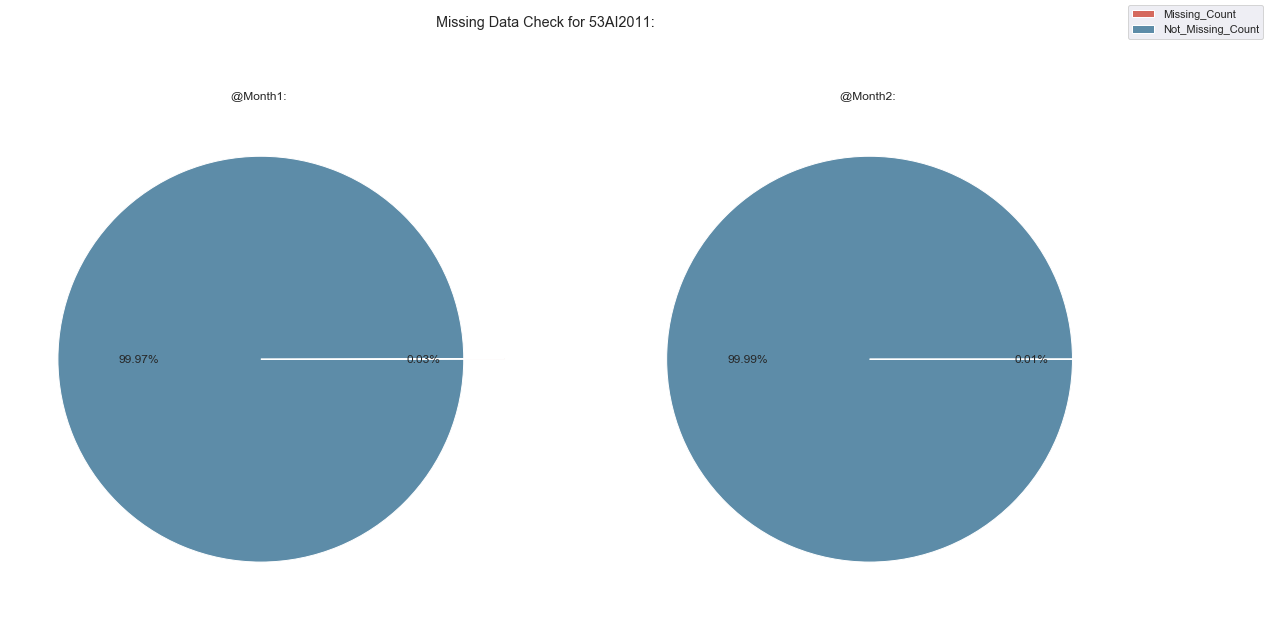

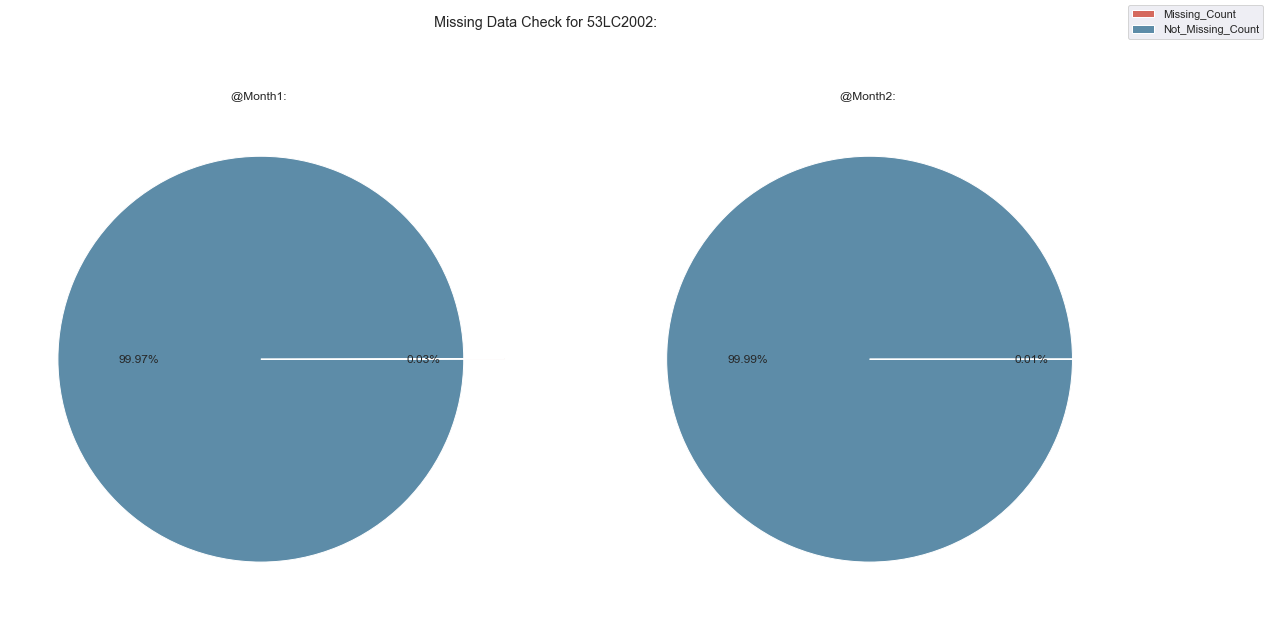

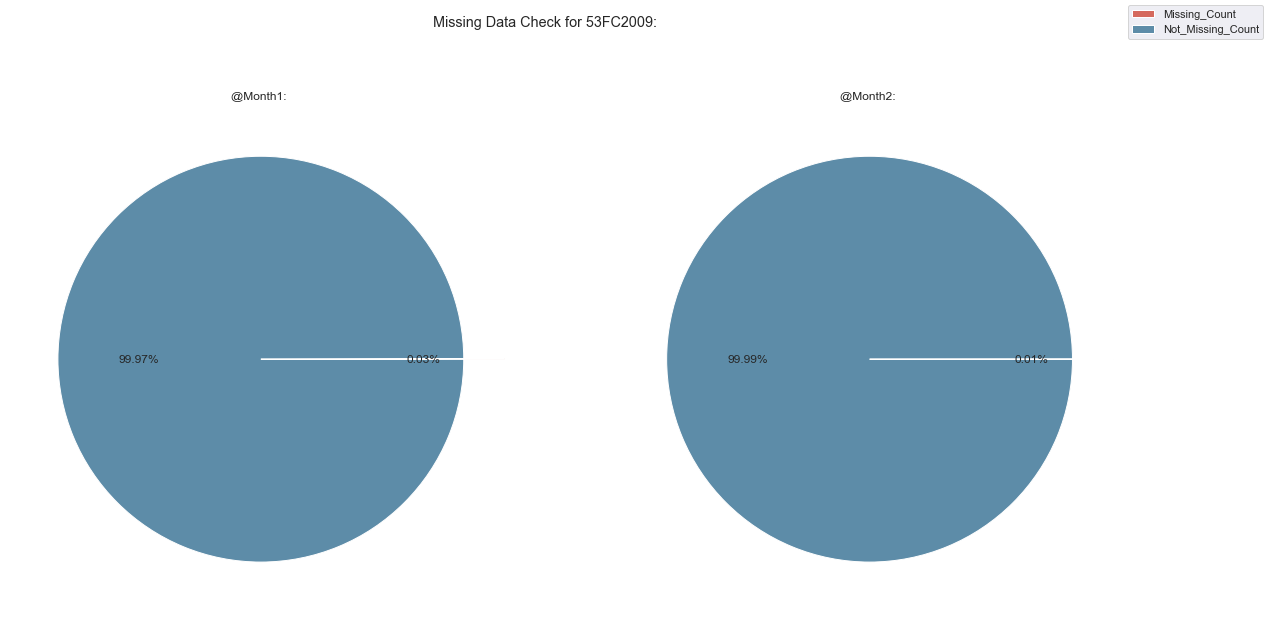

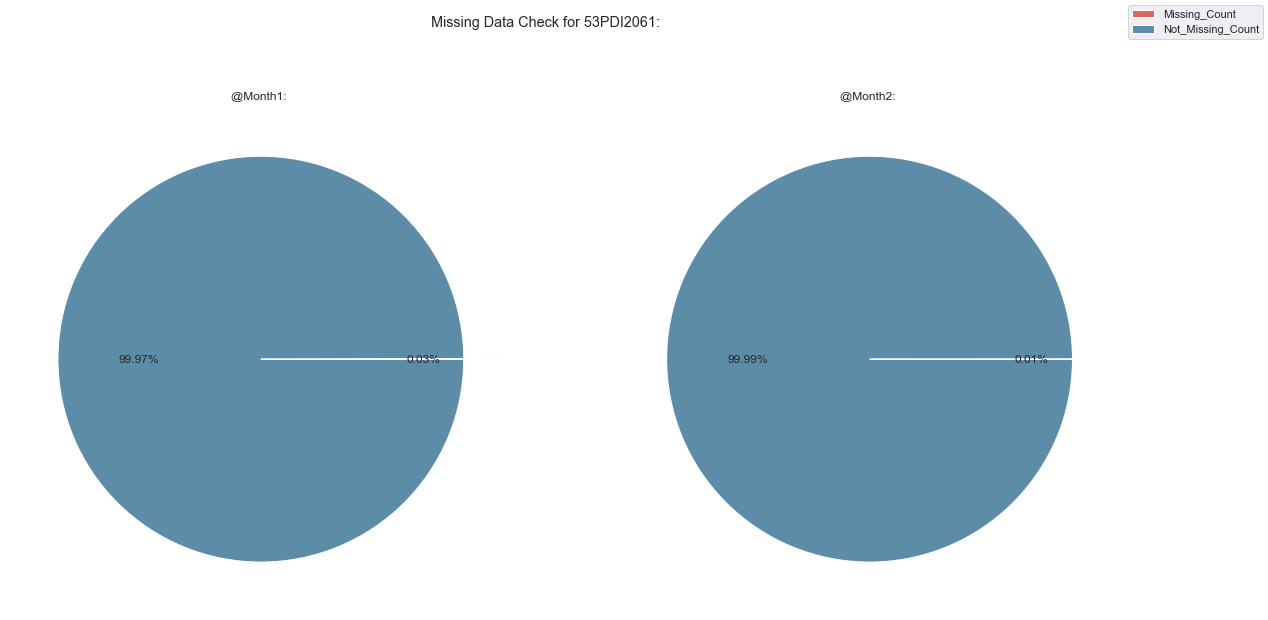

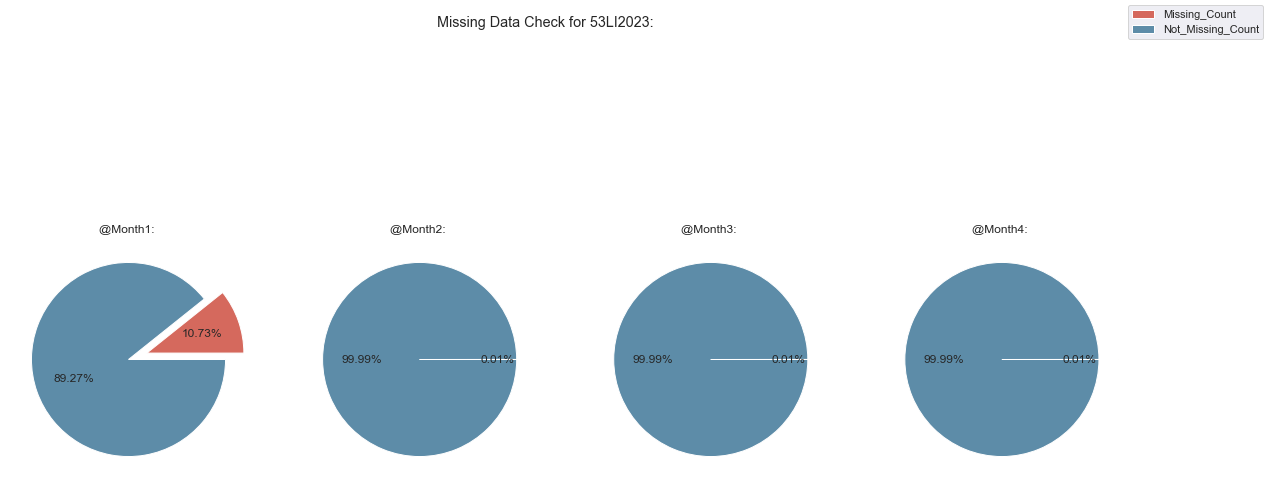

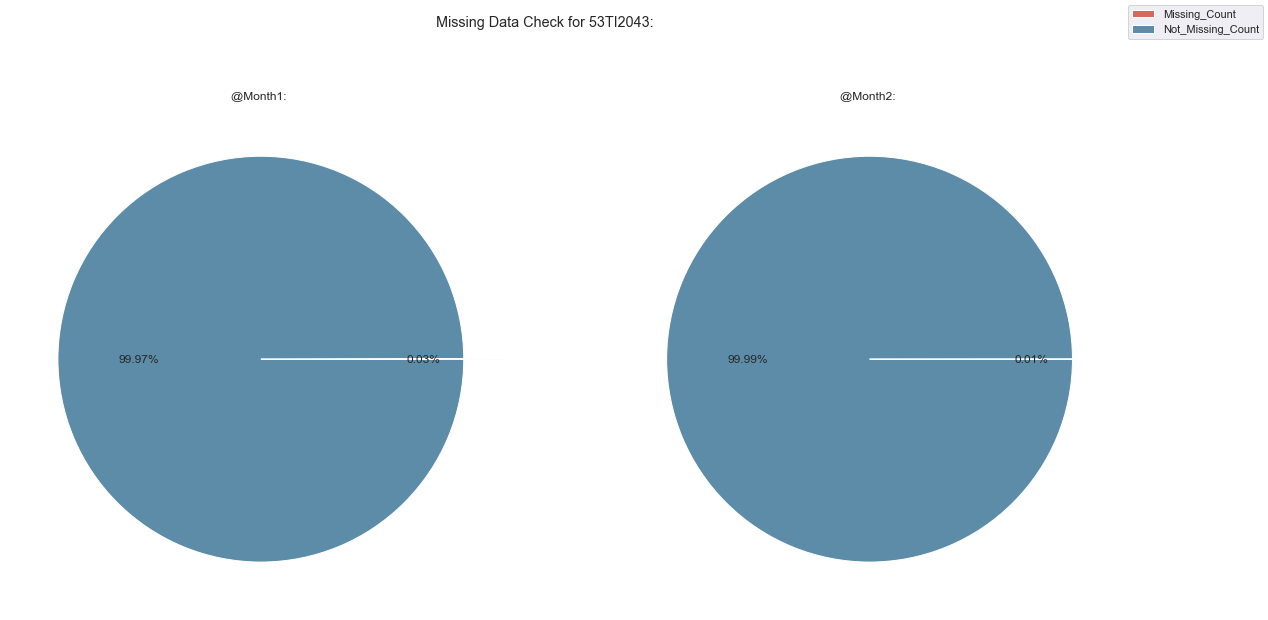

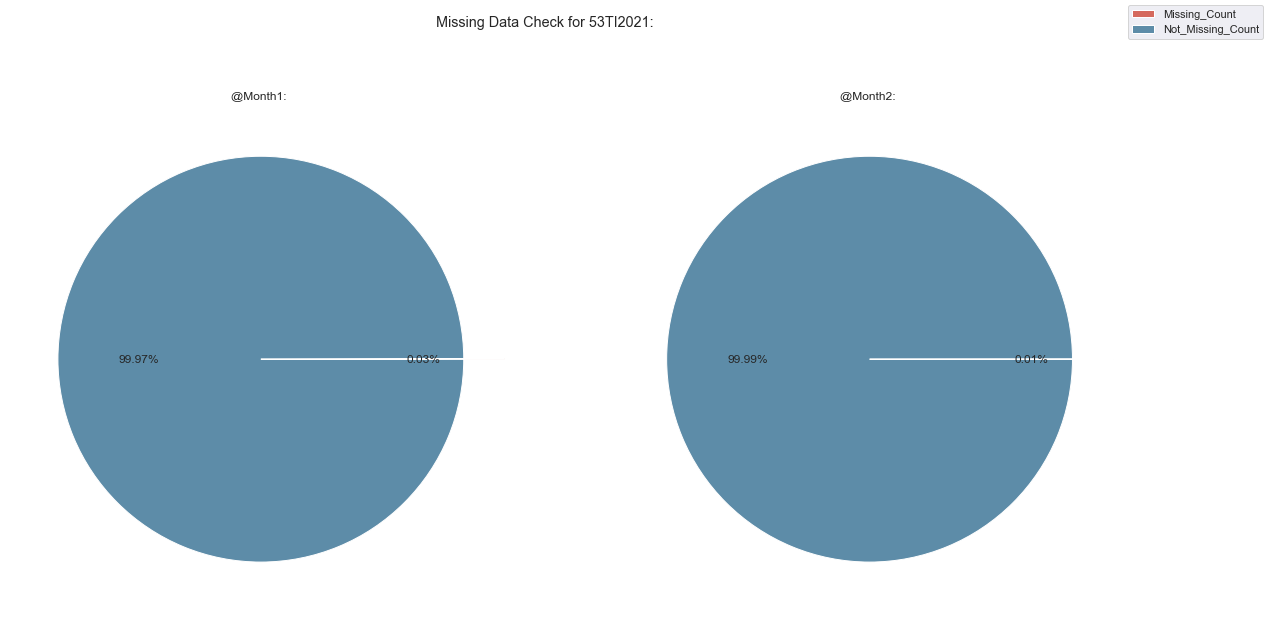

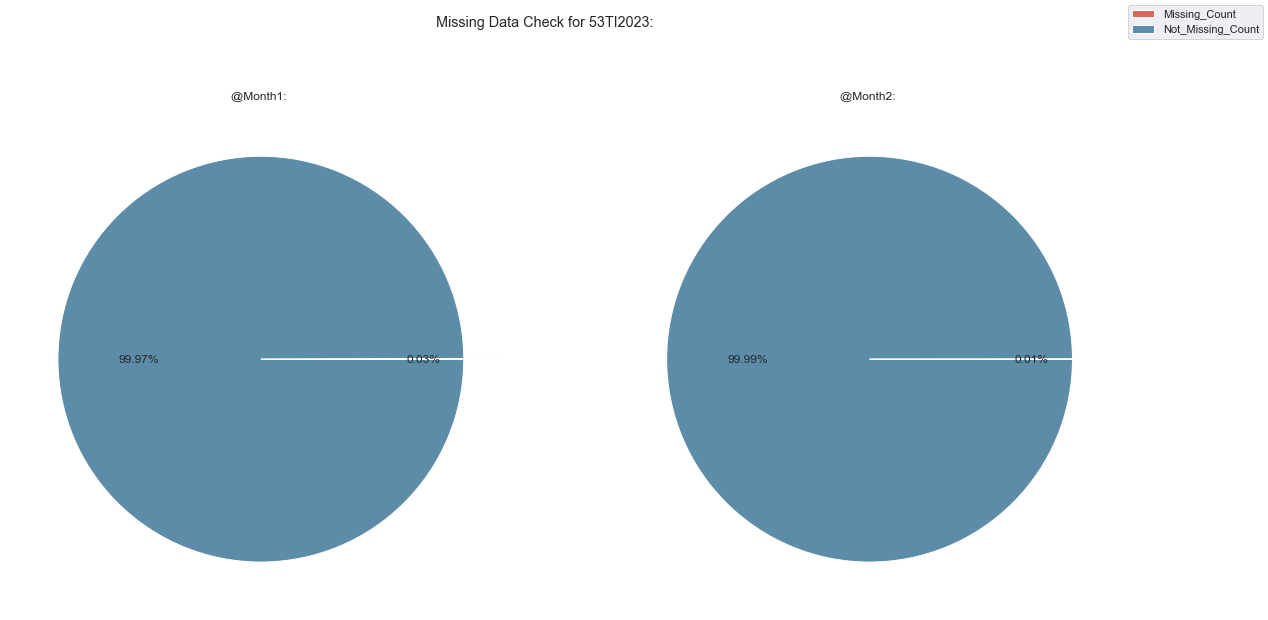

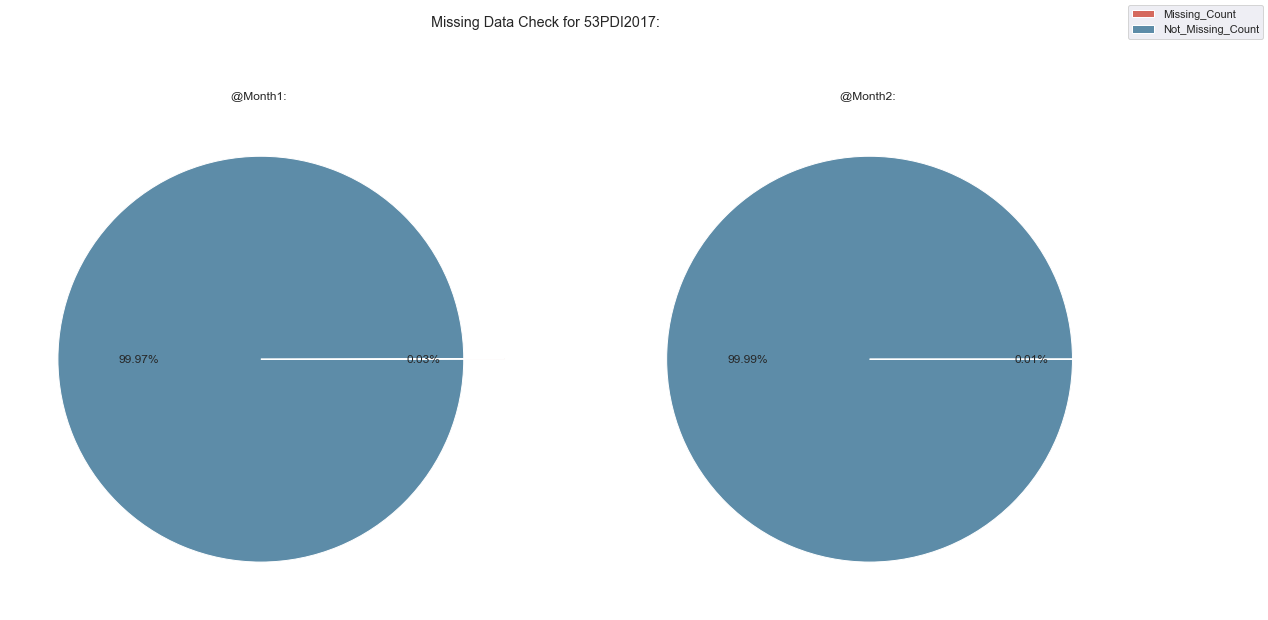

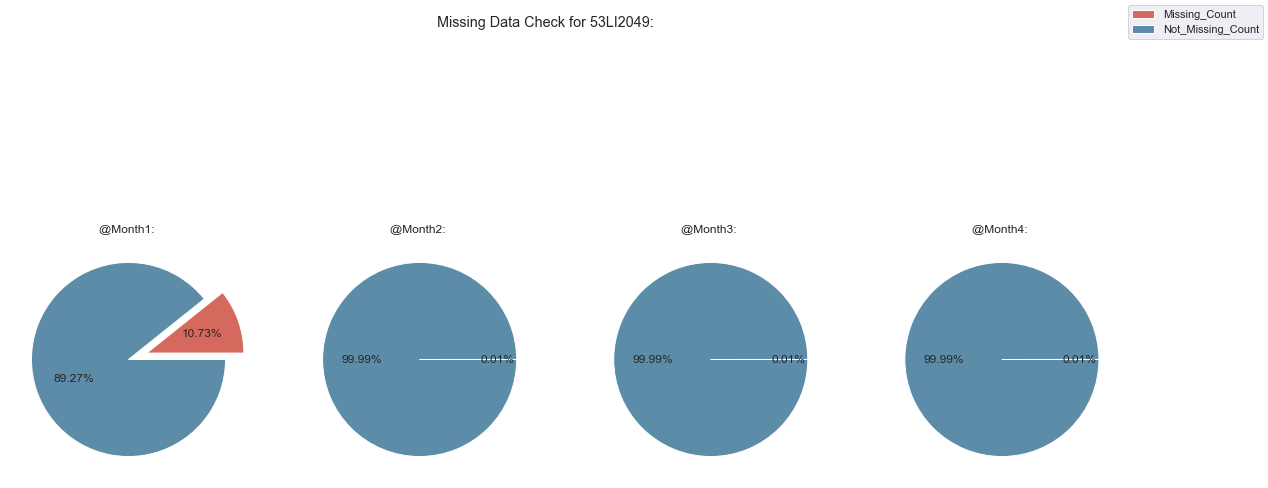

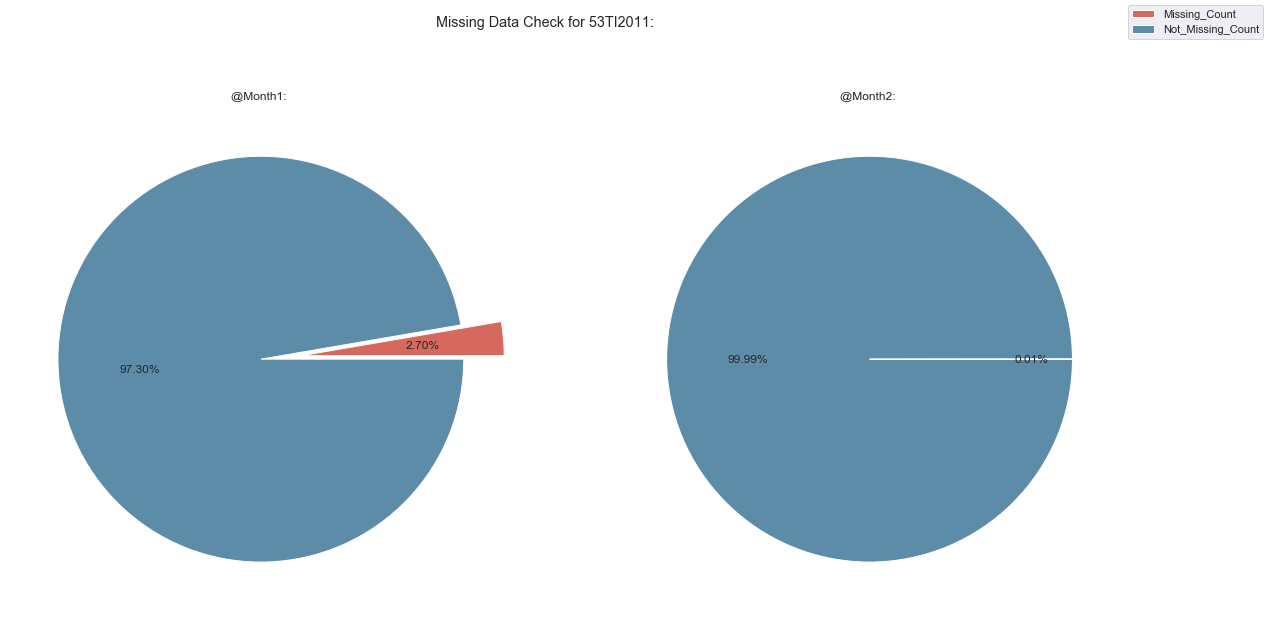

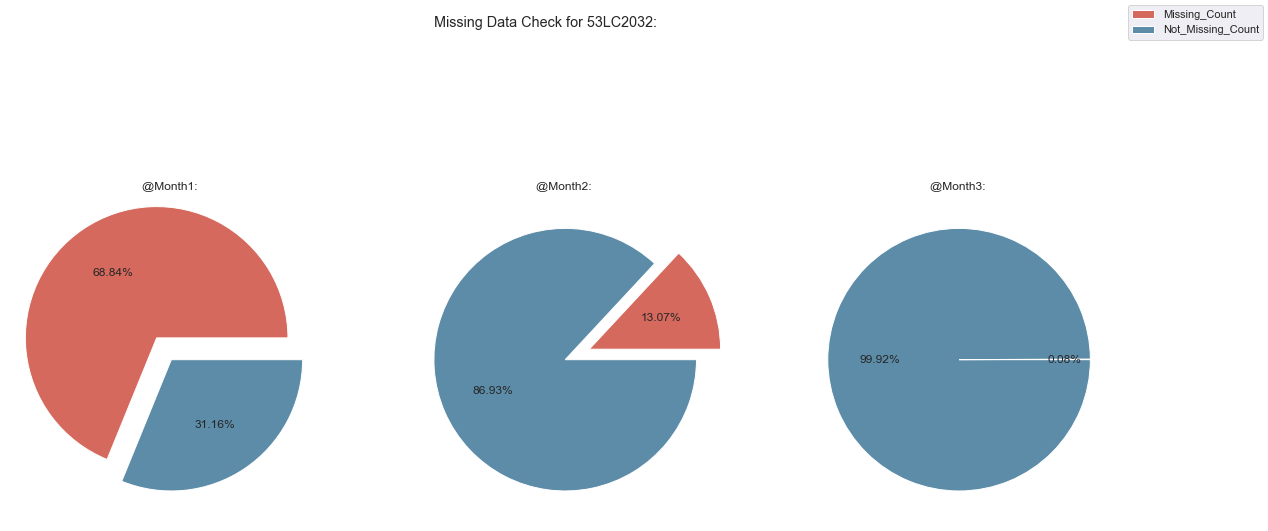

In [784]:
# Save to folder
for col in df.columns:
    fig = visual_monthly_missing(df, col)
    if type(fig) != str:
        fig.savefig(path + '/Missing_Tag_Plot[{}].png'.format(col))

### Distribution

In [847]:
# Directory
directory = 'Distribution_visual'
  
# Parent directory
parent_dir = './Reports/{}/'.format(model)
  
# Path
path = os.path.join(parent_dir, directory)

# Make directory
os.mkdir(path)
print("Directory '% s' created" % directory)

Directory 'Distribution_visual' created


C:\Users\XiaoShuoCui\anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


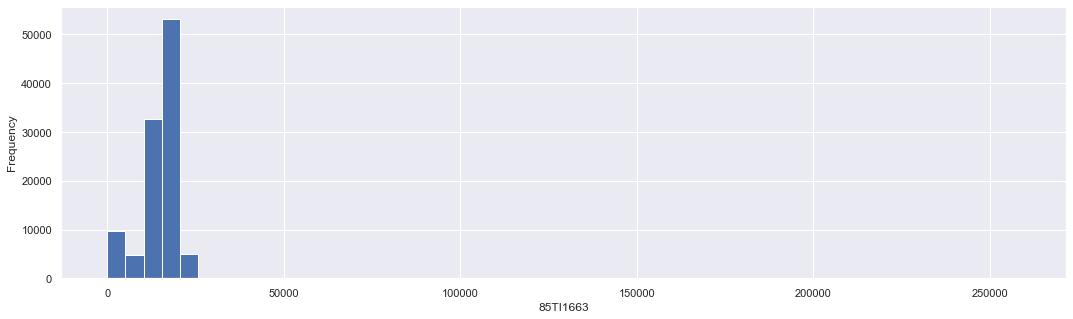

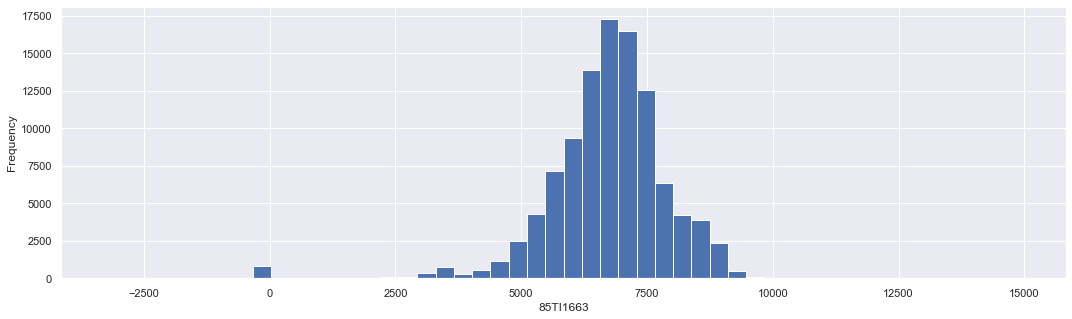

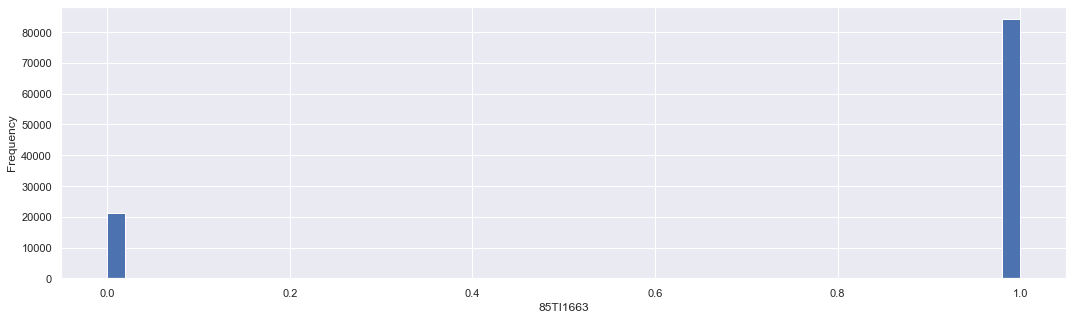

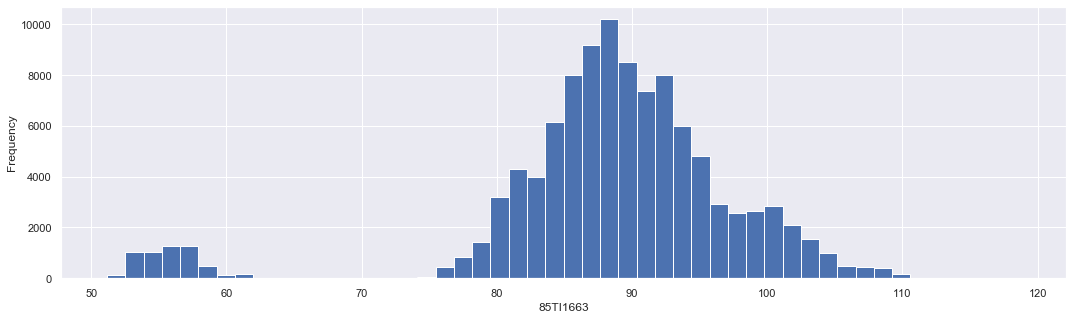

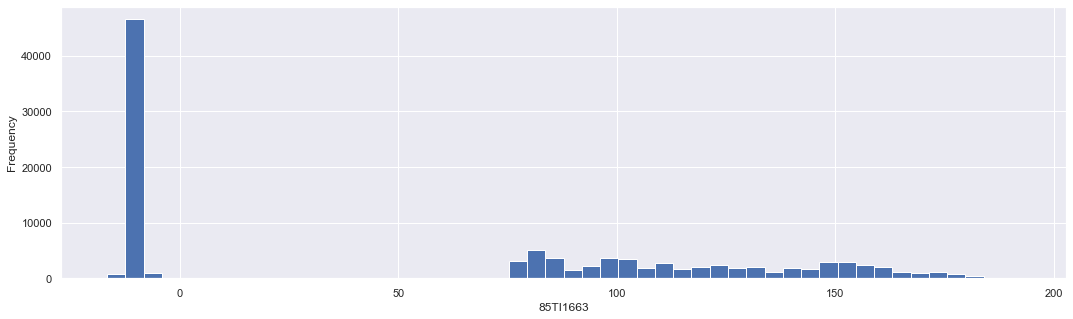

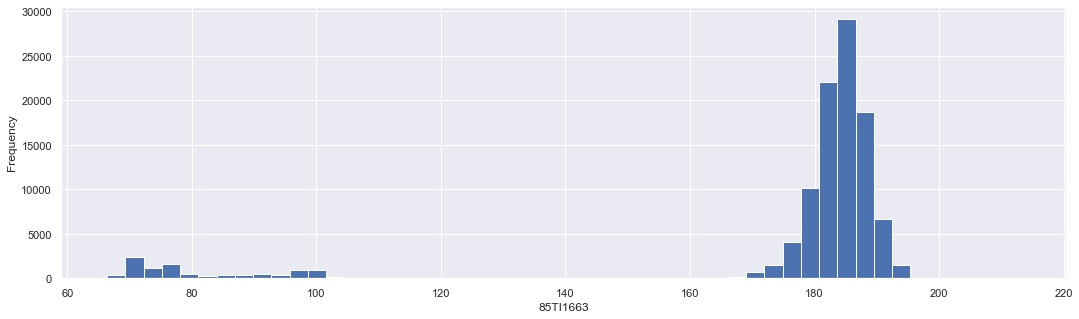

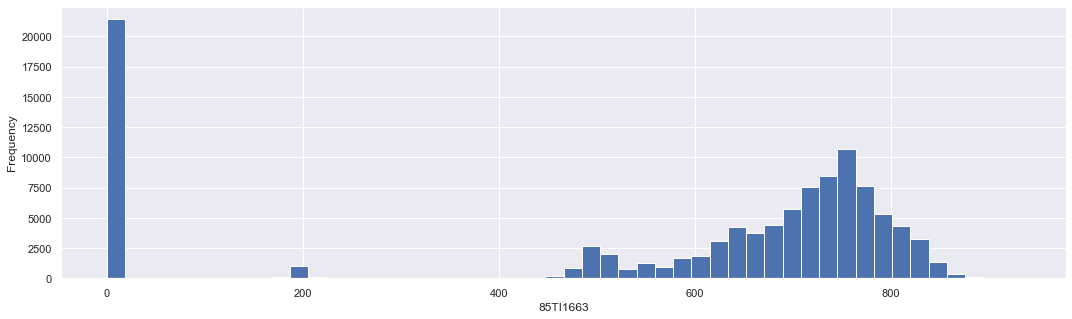

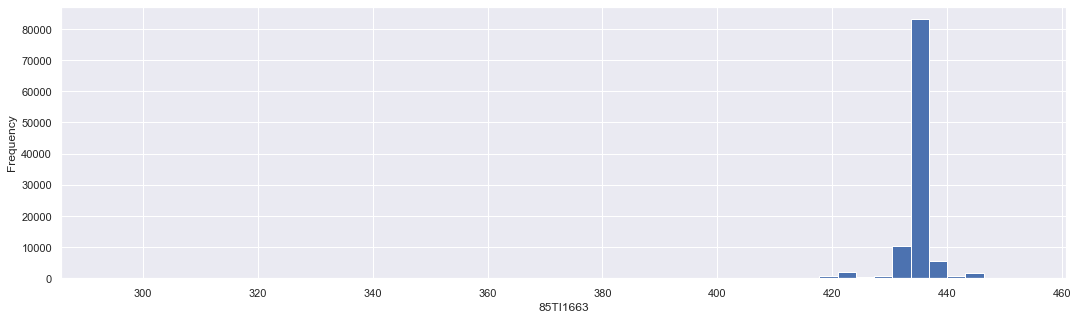

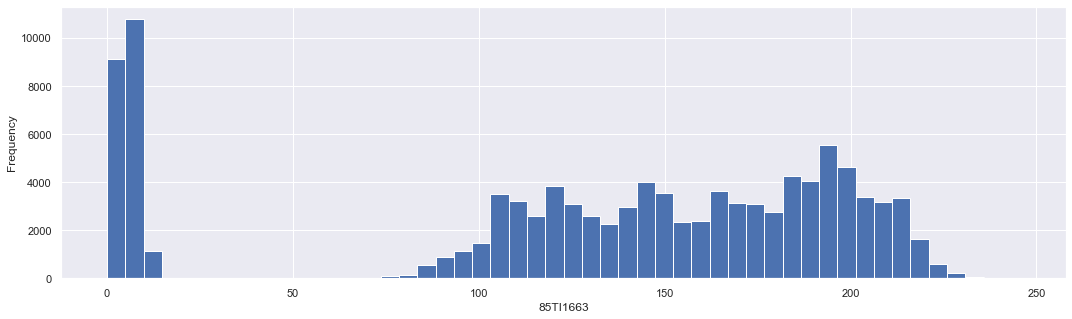

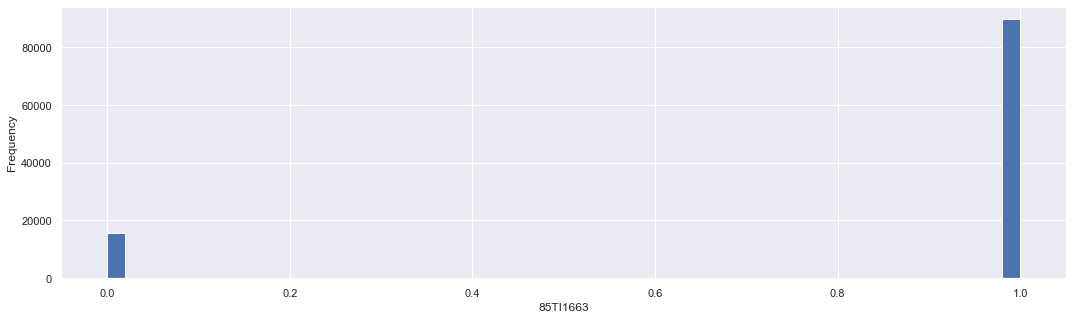

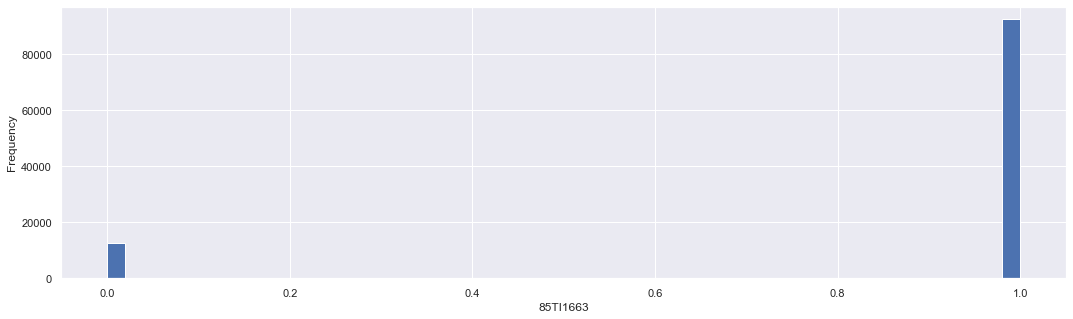

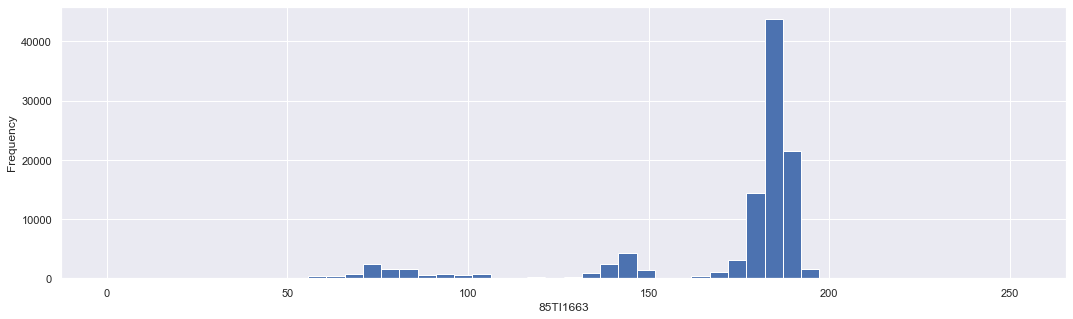

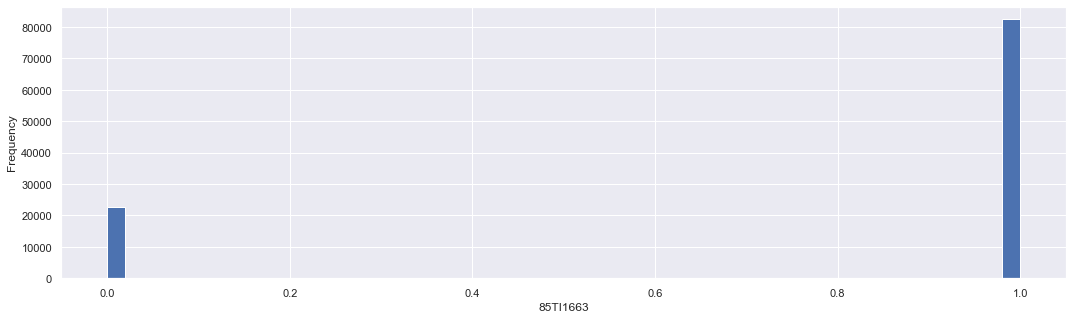

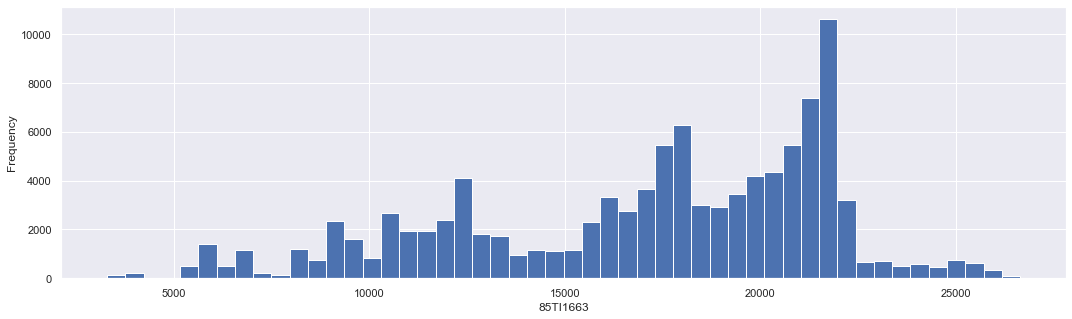

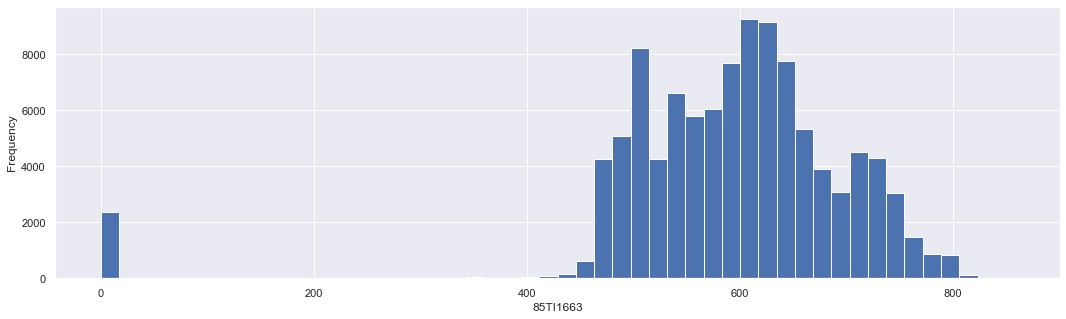

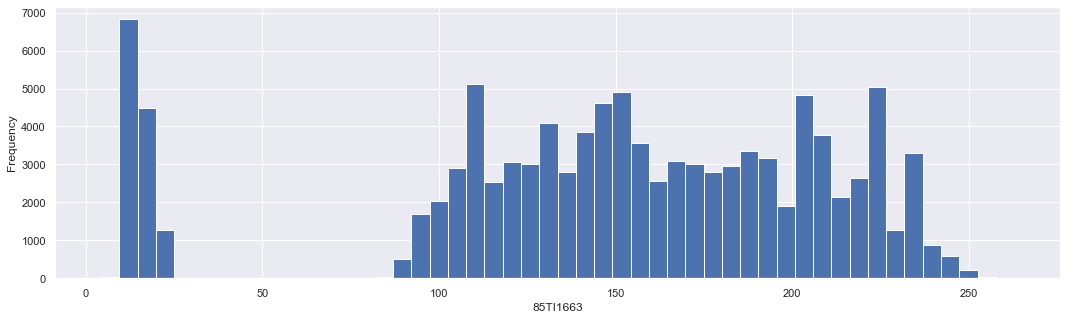

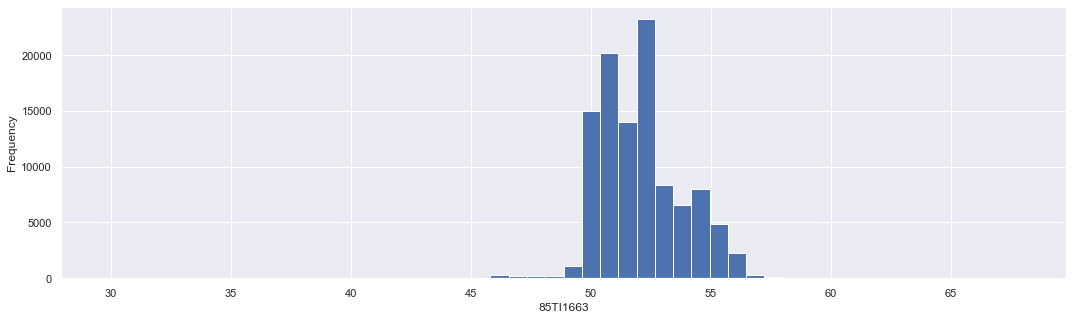

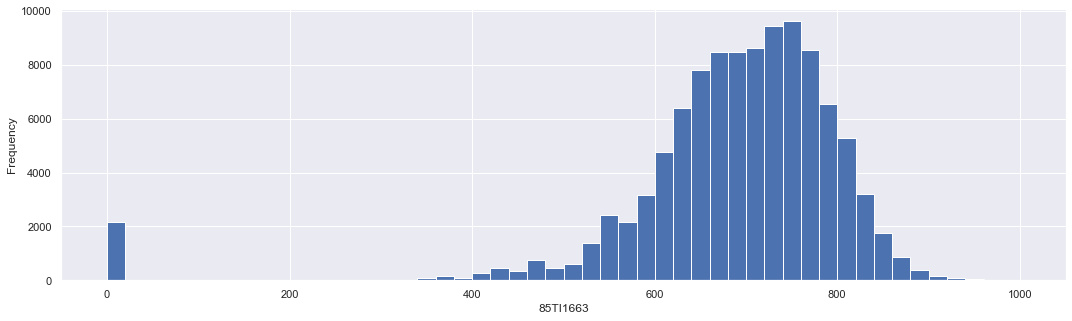

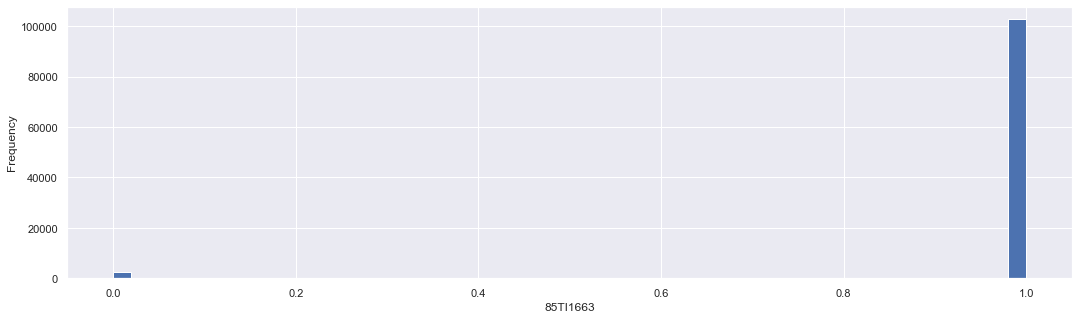

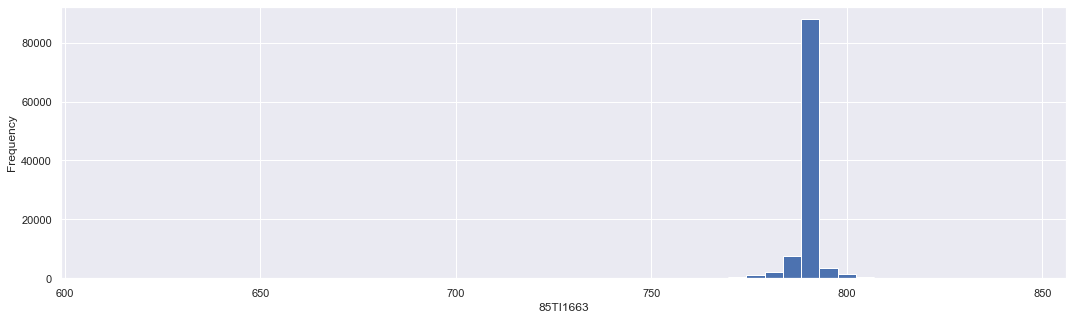

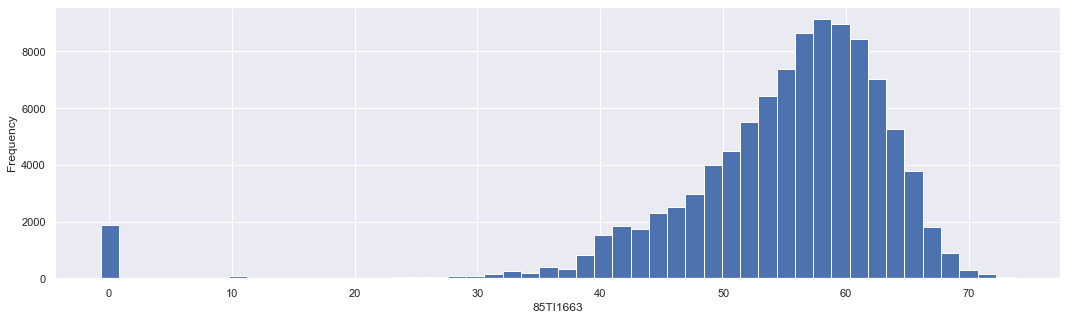

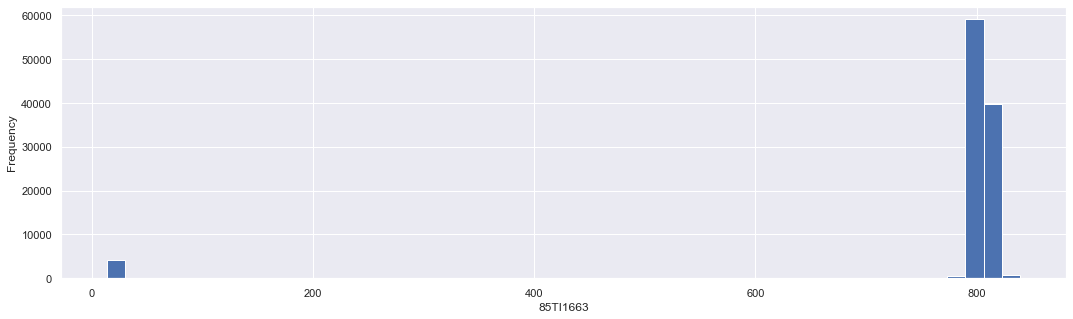

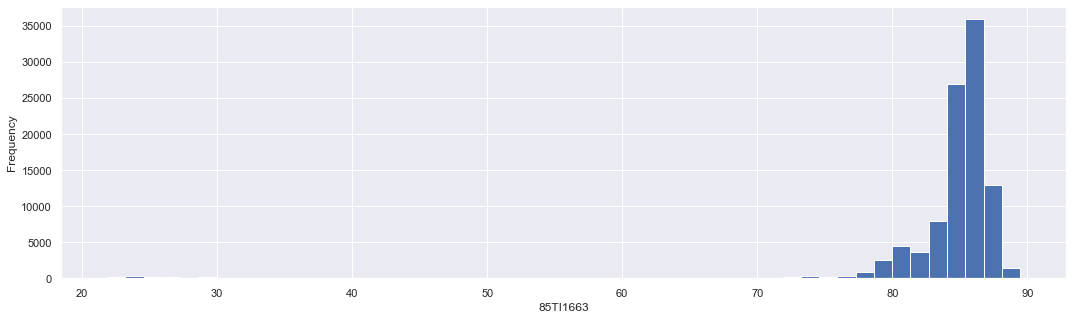

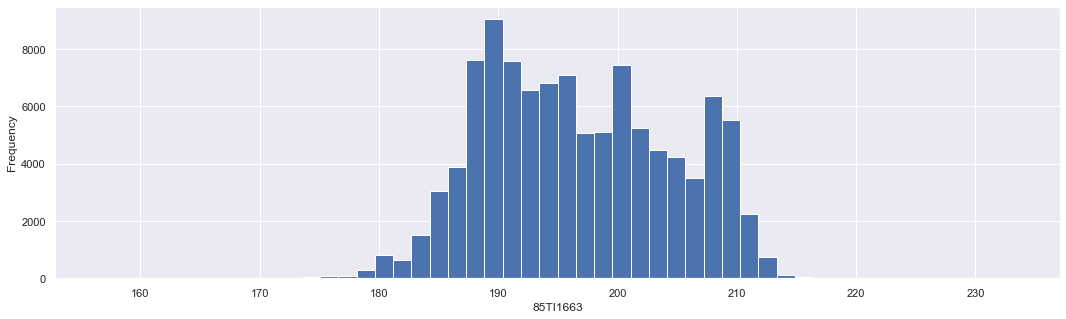

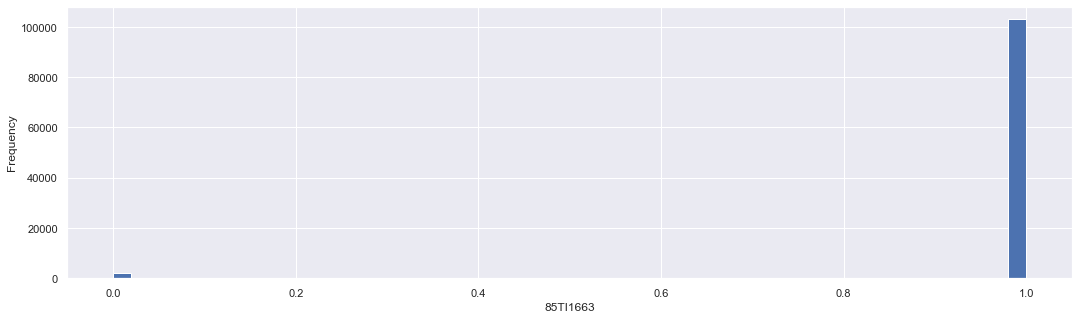

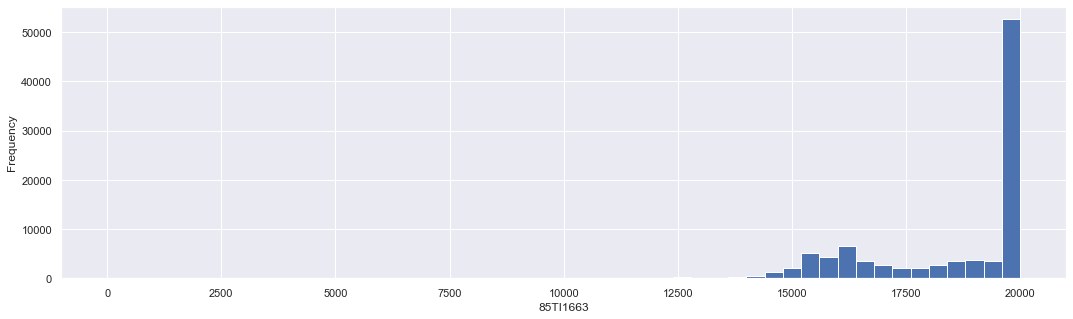

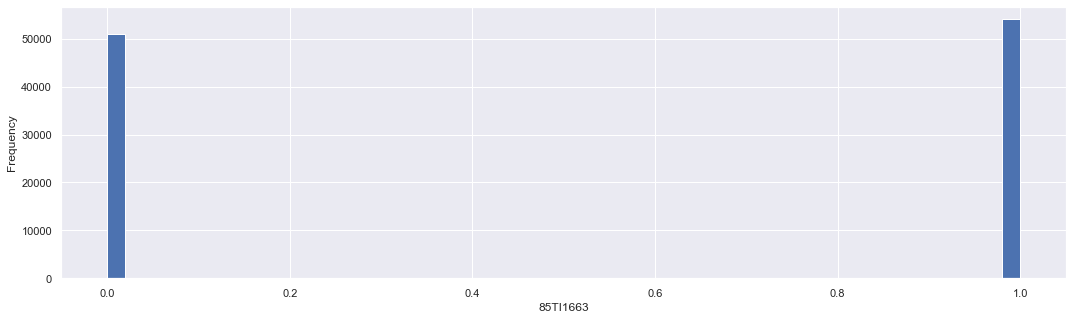

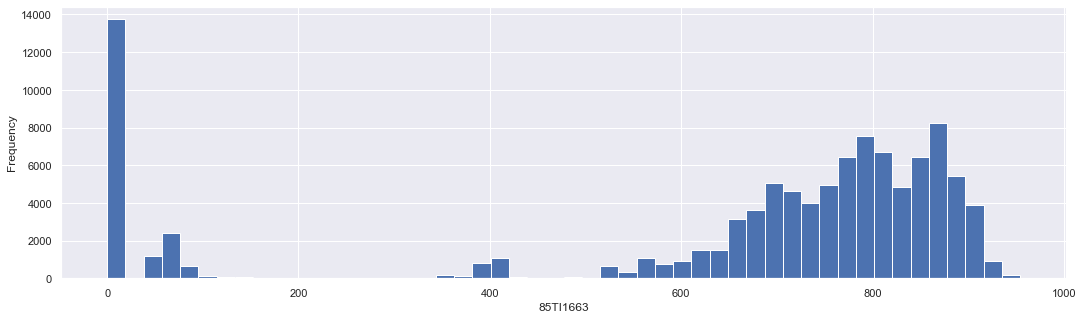

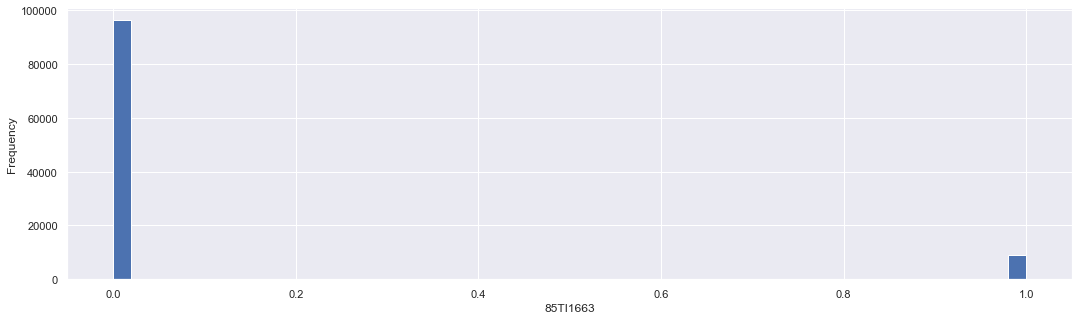

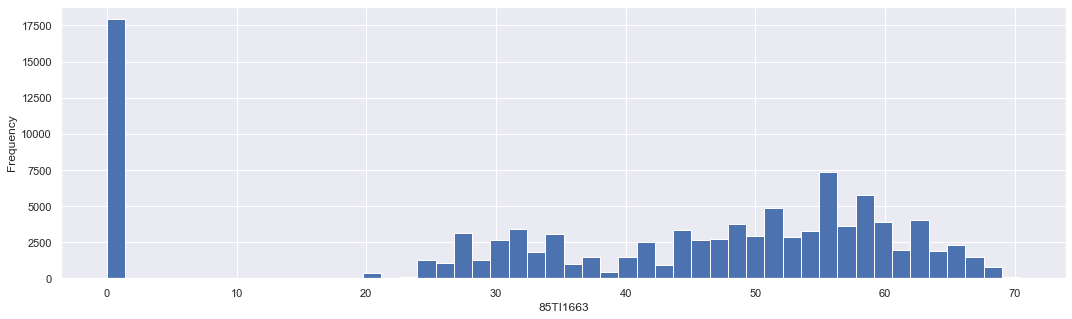

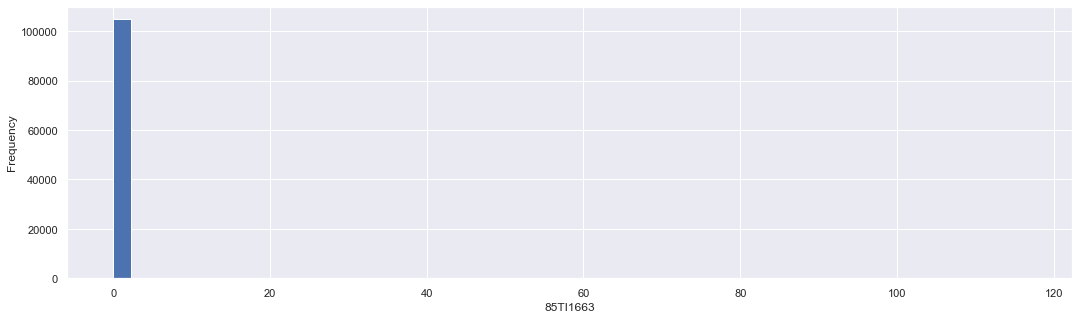

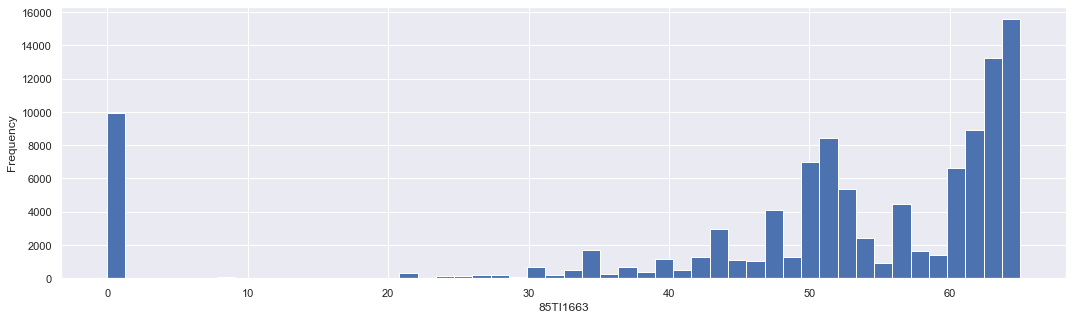

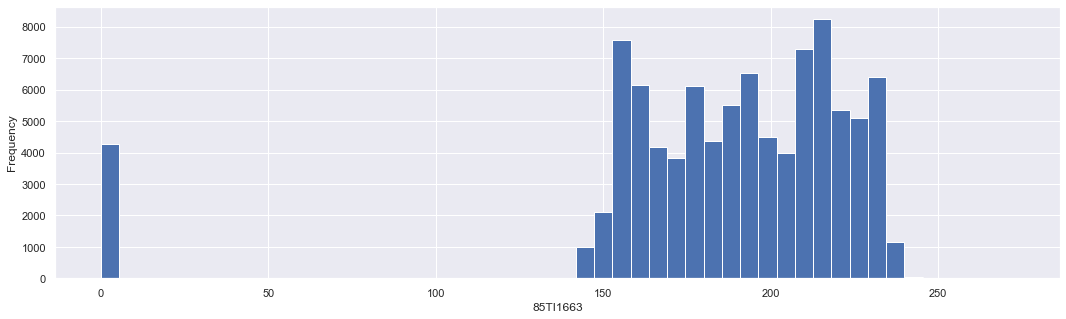

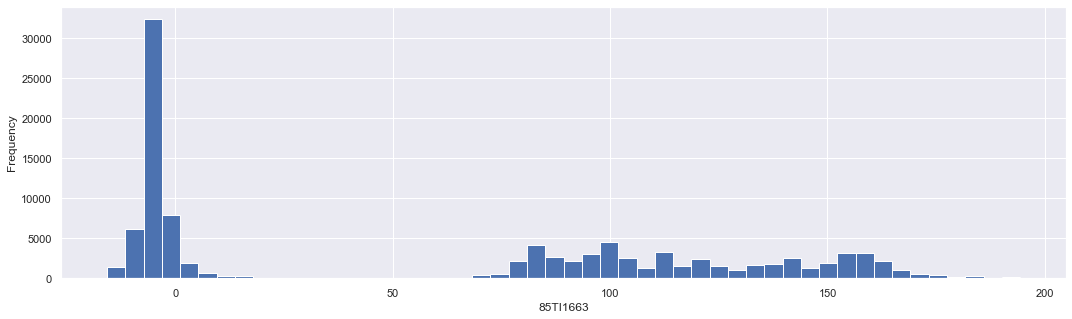

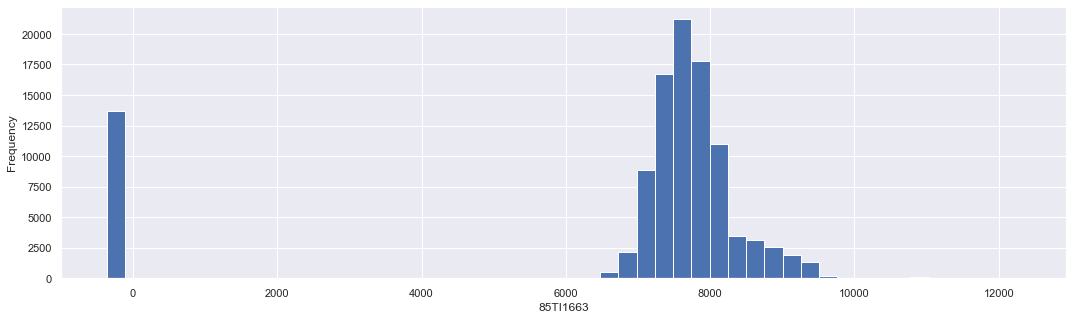

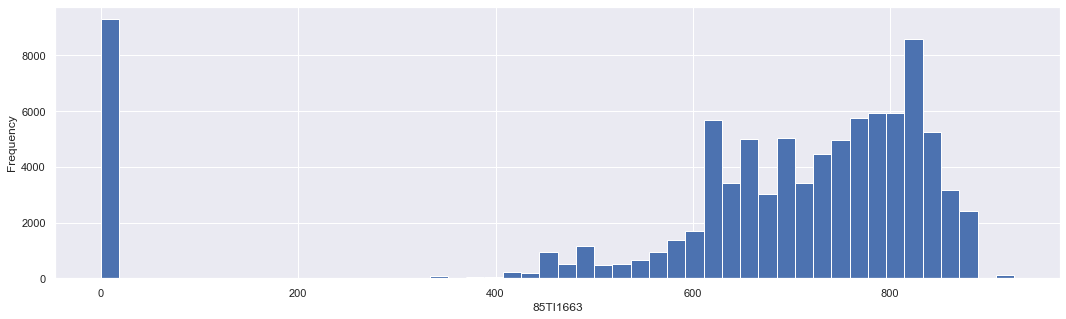

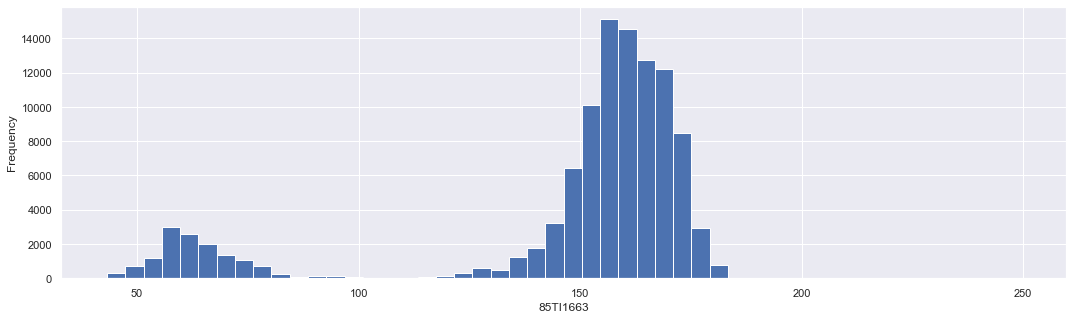

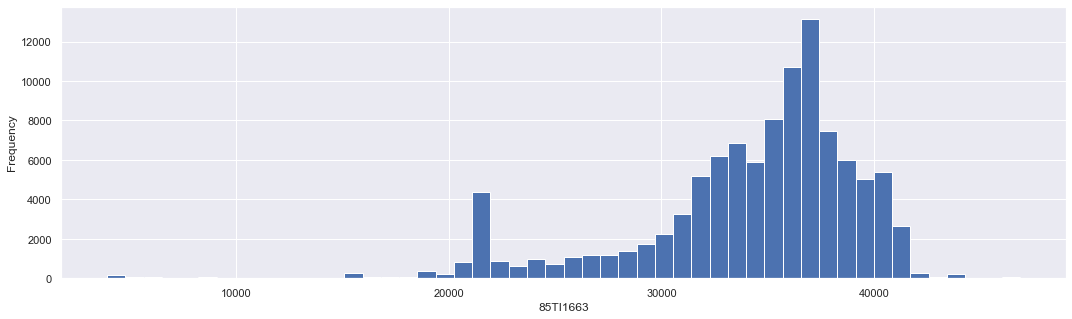

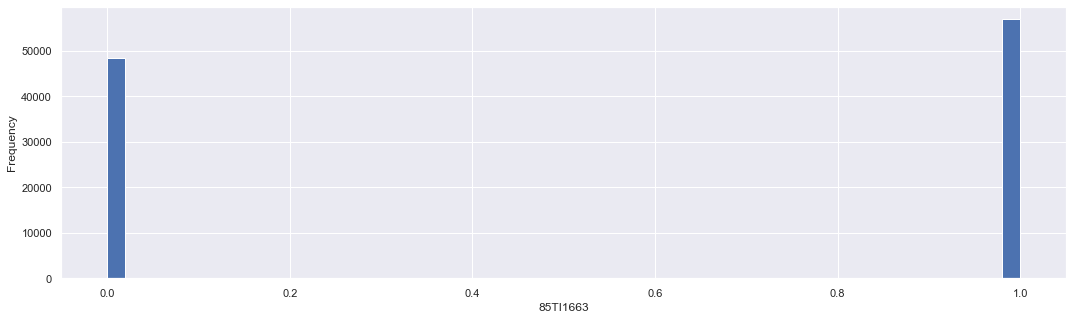

In [848]:
# Save to folder
for col in df.columns:
    fig, ax = plt.subplots(figsize=(18,5))
    plot_hist_distribution(df, '85TI1663', ax=ax)
    fig.savefig(path + '/Tag_Distribution_Plot[{}].png'.format(col))

### Outlier

In [785]:
# List of options: (out of function var)
list_tag = df.columns.to_list()

In [786]:
# Interactive plotting
result = interact(interactive_plotting_outlier, name=list_tag)

interactive(children=(Dropdown(description='name', options=('53AI2011', '53FI2021', '53LC2002', '53FC2009', '5…

## Statistical Distribution Check

- The individual entry can be fit into into 5 groups based on business purpose:
    - Ore grade and quality, tonnage rate related tag
    - Hydro-transportation procedure related tag
    - Tailing procedure related tag
    - Flotation related tag
    - Temperature related tag
- The following section visualize the data distribution w.r.t. the target for each of the group

In [788]:
from upset_flagger.upset.data_utilities import find_new_measurements_max_period
from models.quality.threshold_and_evaluate import flagger
import models.quality.froth_quality
from upset_flagger.upset.tag_utilities import make_df

In [792]:
def plot_stacked_bars(dataframe, title_, size_=(18, 10), rot_=0, legend_="upper right"):
    """
    Plot stacked bars with annotations
    dataframe: should be a (nrows x 2 column) size dataframe, with sum of column = 100 for each row
    """
    ax = dataframe.plot(
        kind="bar",
        stacked=True,
        figsize=size_,
        rot=rot_,
        title=title_
    )

    # Annotate bars
    annotate_stacked_bars(ax, textsize=14)
    # Rename legend
    plt.legend(["Normal", "Bad-Quality"], loc=legend_)
    # Labels
    plt.ylabel("Company base (%)")
    plt.show()

def annotate_stacked_bars(ax, pad=0.99, colour="white", textsize=13):
    """
    Add value annotations to the bars
    """

    # Iterate over the plotted rectanges/bars
    for p in ax.patches:
        
        # Calculate annotation
        value = str(round(p.get_height(),1))
        # If value is 0 do not annotate
        if value == '0.0':
            continue
        ax.annotate(
            value,
            ((p.get_x()+ p.get_width()/2)*pad-0.05, (p.get_y()+p.get_height()/2)*pad),
            color=colour,
            size=textsize
        )

def plot_distribution(dataframe, column, ax, target_tag_class, bins_=50):
    """
    Plot variable distirbution in a stacked histogram of churned or retained company
    """
    # Create a temporal dataframe with the data to be plot
    temp = pd.DataFrame({"Normal": dataframe[dataframe[target_tag_class]==0][column],
    "Bad-Quality":dataframe[dataframe[target_tag_class]==1][column]})
    # Plot the histogram
    temp[["Normal","Bad-Quality"]].plot(kind='hist', bins=bins_, ax=ax, stacked=True)
    # X-axis label
    ax.set_xlabel(column)
    # Change the x-axis to plain style
    ax.ticklabel_format(style='plain', axis='x')


### Prepare Target Data

In [ ]:
# Calculate target column
target_thres = {'MILLMIN': [14, 1],
                'MILLH2O': [30, 1],
                'SBMIN': [14, 1],
                'SBH2O': [30, 1],
               }
target_tag = tag_dict[model]
target_tag_class = target_tag + "_class"
df_target = flagger(df, target_tag, target_thres[model][0], target_thres[model][1])
df_target[target_tag_class] = df_target[target_tag_class]*1

In [21]:
df_target['P86_FROTH_WATER_class'].value_counts()

0    443340
1     82550
Name: P86_FROTH_WATER_class, dtype: int64

### Target distribution

In [22]:
# Prepare target data
target = df_target[[target_tag, target_tag_class]]
target.columns = ['Measurement', 'Target']

In [23]:
# Calculate total num of bad-quality
target_total = target.groupby('Target').count()  # equivalent to churn['churn'].value_counts()
target_total

,Measurement
Target,
0,443340
1,82550


In [24]:
# Calculate percentage of bad-quality
target_percentage = target_total / target_total.sum() * 100
target_percentage.transpose()

Target,0,1
Measurement,84.302801,15.697199


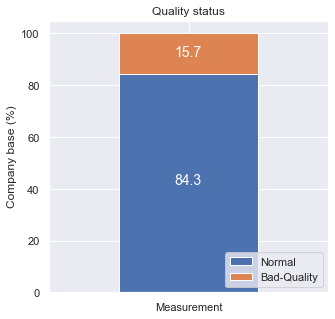

In [48]:
# Plot stacked bars
plot_stacked_bars(target_percentage.transpose(), "Quality status", (5, 5), legend_="lower right")

### Ore grade distribution

In [49]:
df_target[[col for col in df_target if col.startswith('P85_')]].describe()

,P85_OPPA_FINES_30M,P85_OPPB_FINES_30M,P85_OPPC_FINES_30M,P85_OPPA_D50_30M,P85_OPPB_D50_30M,P85_OPPC_D50_30M,P85_OPPA_MB_30M,P85_OPPB_MB_30M,P85_OPPC_MB_30M,P85_OPPA_BPT_30M,P85_OPPB_BPT_30M,P85_OPPC_BPT_30M,P85_OPPA_CL,P85_OPPB_CL,P85_OPPC_CL
count,525890.000000,525889.000000,525890.000000,525890.000000,525890.000000,525890.000000,525889.000000,525890.000000,525889.000000,525890.000000,525889.000000,525890.000000,525890.000000,525867.000000,525872.000000
mean,12.619526,12.320374,12.679620,167.019938,166.433892,168.360912,150.653136,146.513783,155.551069,0.695674,0.687106,0.698059,85.919135,85.157189,84.955139
std,3.896666,3.894274,3.346908,31.611781,32.896790,25.896817,59.518946,59.791502,54.429001,0.102254,0.125445,0.088290,25.579382,24.499265,23.879496
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,9.956000,9.898623,10.201673,152.066125,150.709950,154.378475,109.160000,108.805000,117.780000,0.656132,0.659661,0.659840,69.666978,69.196890,68.887898
50%,12.301310,12.168890,12.433795,171.429700,170.955400,171.316100,144.500000,144.126650,147.974200,0.708167,0.706000,0.706280,81.516365,81.213810,80.561785
75%,14.664000,14.412000,14.995243,185.130000,185.358025,182.870000,180.195700,175.330050,185.338400,0.749891,0.749000,0.749419,99.174015,98.892950,98.431532
max,45.371000,46.009000,40.322540,348.810000,477.080000,355.580300,672.420000,575.406500,561.200000,8.654102,0.988000,9.558633,304.000000,387.263200,397.483700


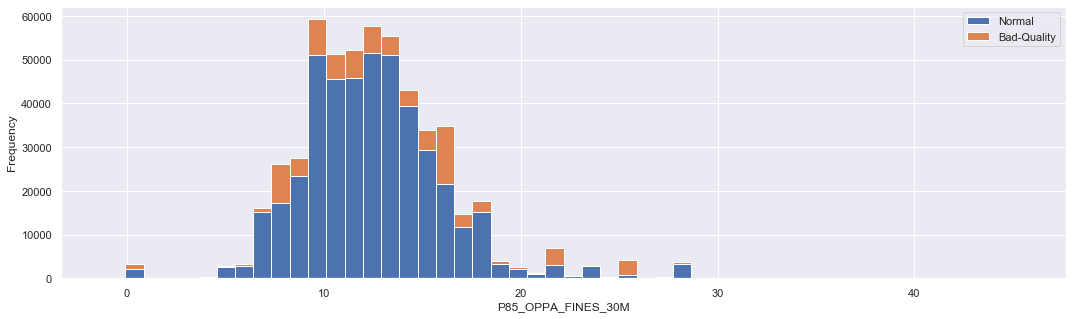

In [50]:
# Individual group distribution
fig, ax = plt.subplots(figsize=(18,5))
plot_distribution(df_target, 'P85_OPPA_FINES_30M', target_tag_class=target_tag_class, ax=ax)

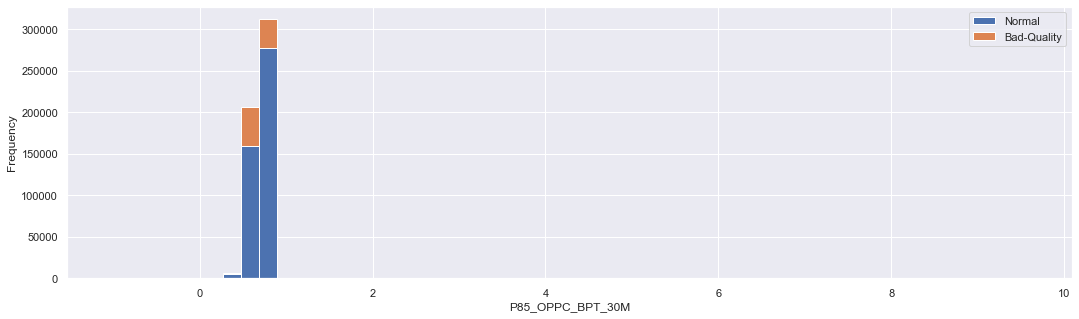

In [51]:
# Individual group distribution
fig, ax = plt.subplots(figsize=(18,5))
plot_distribution(df_target, 'P85_OPPC_BPT_30M', target_tag_class=target_tag_class, ax=ax)

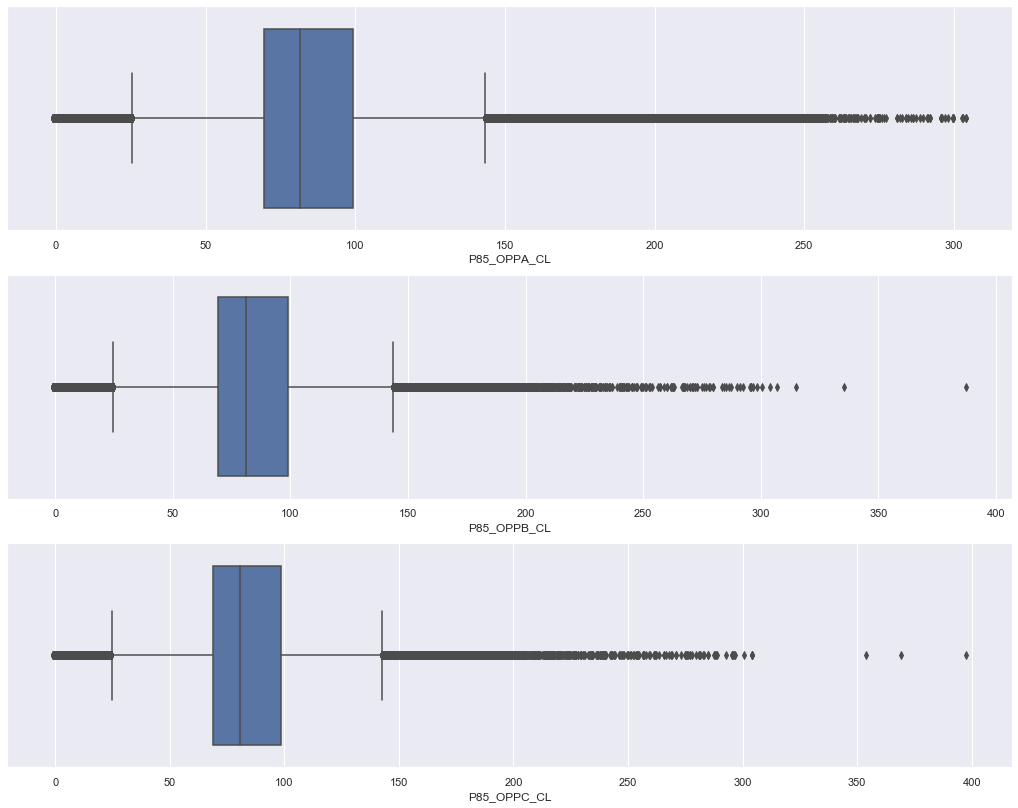

In [68]:
# Plot the statistical distribution if ORE
fig, axs = plt.subplots(nrows=3, figsize=(18,14))

# Plot histogram
sns.boxplot(df_target["P85_OPPA_CL"], ax=axs[0])
sns.boxplot(df_target["P85_OPPB_CL"],ax=axs[1])
sns.boxplot(df_target["P85_OPPC_CL"], ax=axs[2])

# Remove scientific notation
axs[0].ticklabel_format(style='plain', axis='x')
axs[1].ticklabel_format(style='plain', axis='x')
axs[2].ticklabel_format(style='plain', axis='x')
plt.show()

### Tonnage rate distribution

In [52]:
df_target[[col for col in df_target if col.startswith('85WIC')]].describe()

,85WIC1703,85WIC2803,85WIC3803
count,522495.000000,525089.000000,525614.000000
mean,2681.885532,3327.900057,3179.174652
std,2335.452161,2279.107661,2349.496723
min,-2999.998000,0.000000,0.000000
25%,1.000009,1.000023,1.000023
50%,3611.328000,4400.844000,4269.328500
75%,4787.161000,5179.335000,5137.693250
max,12820.420000,51438.880000,52038.020000


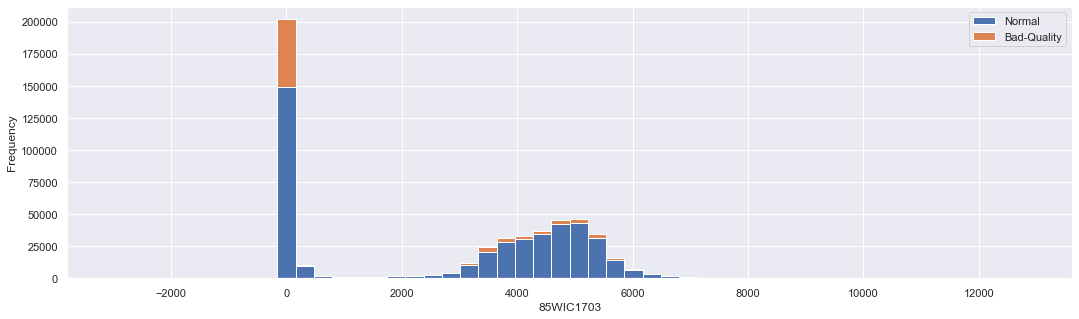

In [53]:
# Individual group distribution
fig, ax = plt.subplots(figsize=(18,5))
plot_distribution(df_target, '85WIC1703', target_tag_class=target_tag_class, ax=ax)

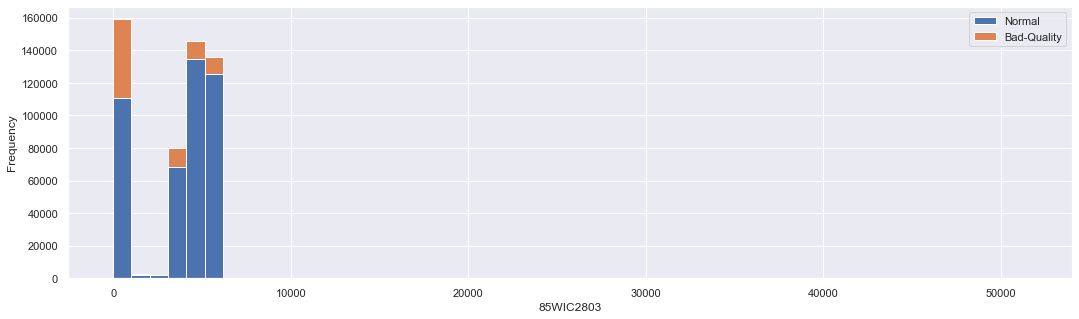

In [54]:
# Individual group distribution
fig, ax = plt.subplots(figsize=(18,5))
plot_distribution(df_target, '85WIC2803', target_tag_class=target_tag_class, ax=ax)

### Hydro Transportation Slurry distribution

In [55]:
df_target[[col for col in df_target if col.startswith('85DI') or col.startswith('85FIC')]].describe()

,85DI1661,85DI2661,85DI3661,85FIC1662,85FIC2662,85FIC3662
count,522389.000000,525166.000000,525625.000000,521354.000000,520043.000000,524263.000000
mean,1.383796,1.461637,1.469807,2807.138233,2908.128161,2907.195530
std,0.339227,0.253419,0.244551,2150.149236,1857.905832,2004.707911
min,0.450000,0.000000,0.450000,-1625.121000,-1625.065000,-1652.790000
25%,1.228478,1.484047,1.489098,-0.111084,0.028076,-2.615234
50%,1.541492,1.529485,1.541792,3900.643500,3725.730000,3919.317000
75%,1.580188,1.554933,1.563408,4606.946000,4213.073500,4407.185000
max,1.768360,1.702996,1.768360,6948.100000,6498.949000,6495.580000


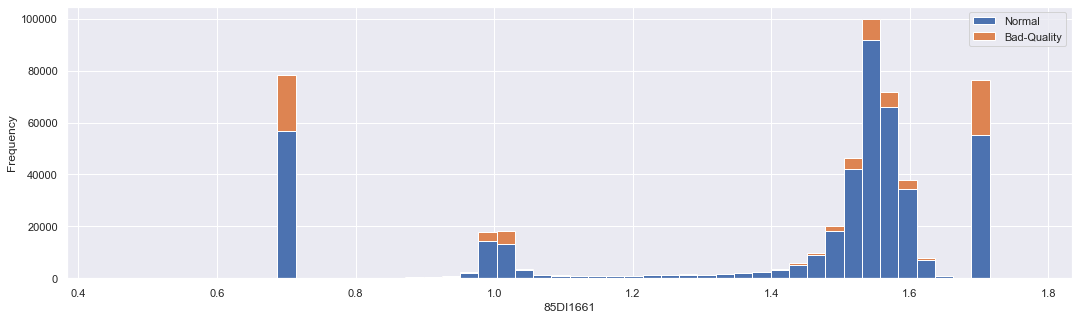

In [56]:
# Individual group distribution
fig, ax = plt.subplots(figsize=(18,5))
plot_distribution(df_target, '85DI1661', target_tag_class=target_tag_class, ax=ax)

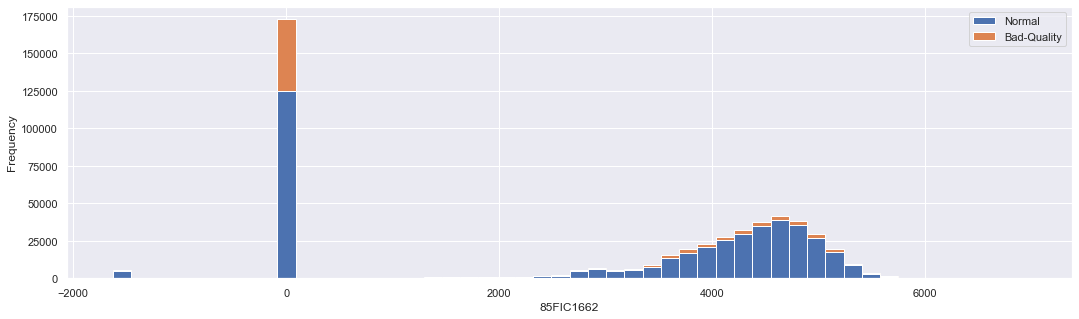

In [57]:
# Individual group distribution
fig, ax = plt.subplots(figsize=(18,5))
plot_distribution(df_target, '85FIC1662', target_tag_class=target_tag_class, ax=ax)

### Tailing distribution

In [58]:
df_target[[col for col in df_target if col.startswith('P86') or col.startswith('86FIC')]].describe()

,P86_FROTH_WATER,P86_L12_TAILS_BIT_PCT,P86_L13_TAILS_BIT_PCT,P86_L14_TAILS_BIT_PCT,86FIC693,86FIC453,86FIC553,P86_FROTH_WATER_class
count,525890.000000,525890.000000,525890.000000,525890.000000,515928.000000,517270.000000,522405.000000,525890.000000
mean,27.049736,0.251217,0.256003,0.244779,4908.778083,4486.019055,4319.631196,0.156972
std,3.213766,0.142333,0.148830,0.135613,2540.764428,2680.261059,2840.067161,0.363775
min,10.350000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,25.040000,0.169894,0.163000,0.166513,5209.796750,0.000000,0.000000,0.000000
50%,26.720000,0.228000,0.236000,0.226000,5968.590500,5800.477000,5819.708000,0.000000
75%,28.750000,0.312000,0.327000,0.311945,6467.498500,6212.551750,6321.378000,0.000000
max,54.240000,4.310000,3.240000,4.520090,8494.634000,8490.904000,8494.200000,1.000000


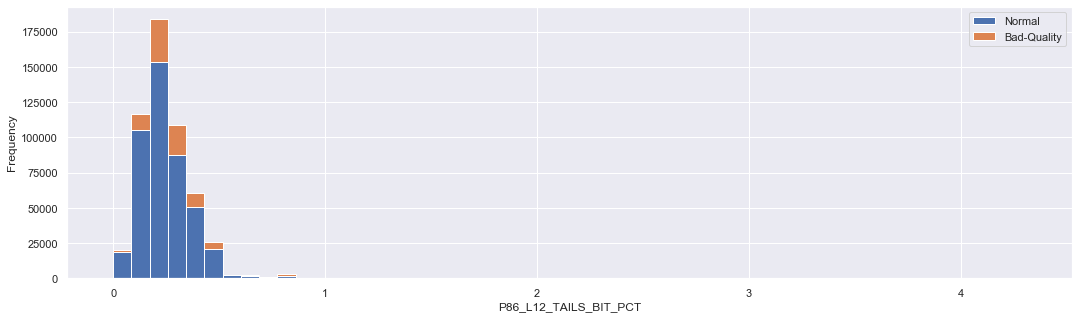

In [59]:
# Individual group distribution
fig, ax = plt.subplots(figsize=(18,5))
plot_distribution(df_target, 'P86_L12_TAILS_BIT_PCT', target_tag_class=target_tag_class, ax=ax)

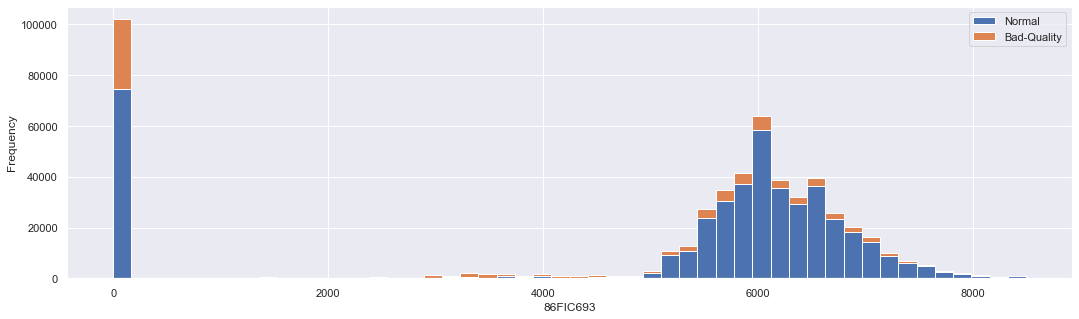

In [60]:
# Individual group distribution
fig, ax = plt.subplots(figsize=(18,5))
plot_distribution(df_target, '86FIC693', target_tag_class=target_tag_class, ax=ax)

### Floatation distribution

In [61]:
df_target[[col for col in df_target if col.startswith('86II')]].describe()

,86II252,86II253,86II255,86II272,86II273,86II275,86II352,86II353,86II355,86II372,86II373,86II375
count,525741.000000,525556.000000,516678.000000,525685.000000,525803.000000,525802.000000,525637.000000,525100.000000,521881.000000,525782.000000,525749.000000,525797.000000
mean,42.040972,40.962639,34.490004,38.660379,34.821711,21.306557,34.488428,33.695809,33.943301,33.950314,37.550467,23.301355
std,29.002099,29.009530,22.539129,30.258403,27.360816,20.028591,29.784221,28.585334,28.177458,31.493707,32.356704,24.714997
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,55.000000,56.000000,45.000000,56.000000,52.000000,26.000000,40.000000,42.000000,46.000000,46.000000,57.000000,24.000000
75%,64.000000,63.000000,50.000000,64.000000,58.000000,27.000000,62.000000,61.000000,59.000000,64.000000,66.000000,25.000000
max,102.000000,102.000000,102.000000,102.000000,100.000000,101.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000


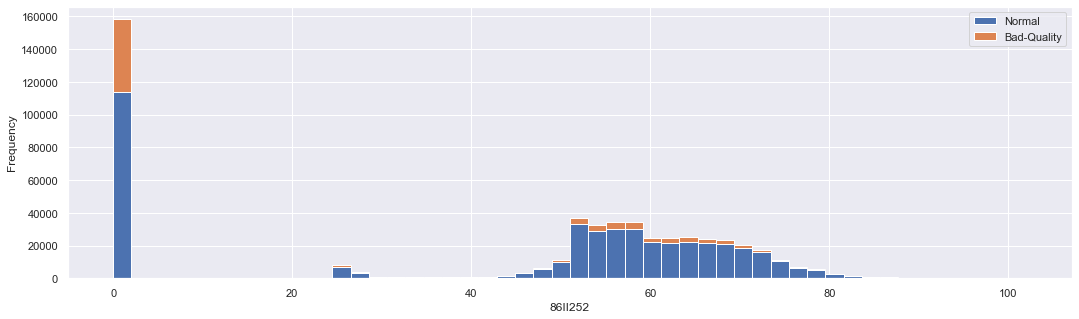

In [62]:
# Individual group distribution
fig, ax = plt.subplots(figsize=(18,5))
plot_distribution(df_target, '86II252', target_tag_class=target_tag_class, ax=ax)

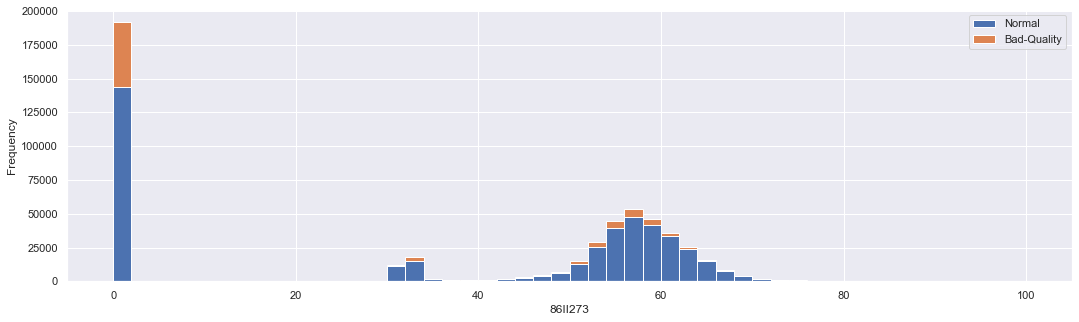

In [63]:
# Individual group distribution
fig, ax = plt.subplots(figsize=(18,5))
plot_distribution(df_target, '86II273', target_tag_class=target_tag_class, ax=ax)

### Temperature distribution

In [64]:
df_target[[col for col in df_target if 'TI' in col]].describe()

,85TI1663,85TI2663,85TI3663,86TI168,86TI188,86TIC209,86TIC309
count,523843.000000,525165.000000,525621.000000,525802.000000,525889.000000,525024.000000,518196.000000
mean,40.447282,74.810606,39.835369,36.249082,13.045829,50.953682,49.037891
std,21.880842,61.727231,19.498537,11.796732,21.778878,13.522694,19.301907
min,-37.379280,-0.963303,-0.910305,0.000000,-17.777780,-17.777800,-17.777800
25%,19.341080,23.386640,24.367120,32.517140,-1.901353,48.465630,37.497330
50%,51.210950,52.577130,49.146940,38.759200,6.774726,52.862540,44.851700
75%,55.394900,155.459300,52.627190,44.238670,35.273060,56.989010,62.624740
max,86.113520,155.459300,82.848210,73.511610,70.346410,97.366040,97.370400


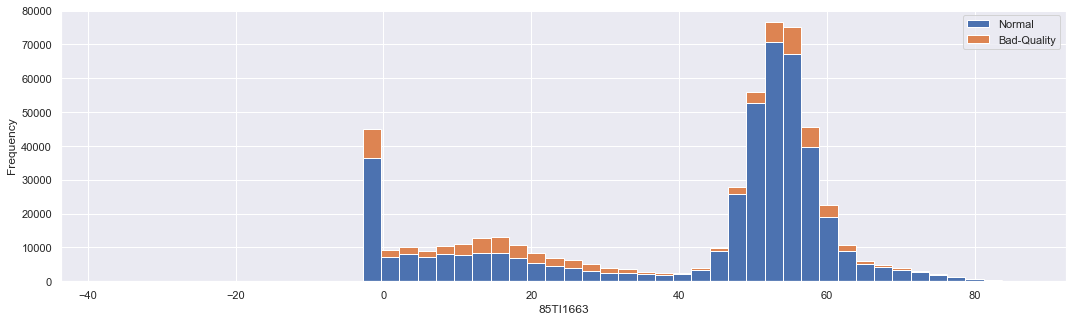

In [65]:
# Individual group distribution
fig, ax = plt.subplots(figsize=(18,5))
plot_distribution(df_target, '85TI1663', target_tag_class=target_tag_class, ax=ax)

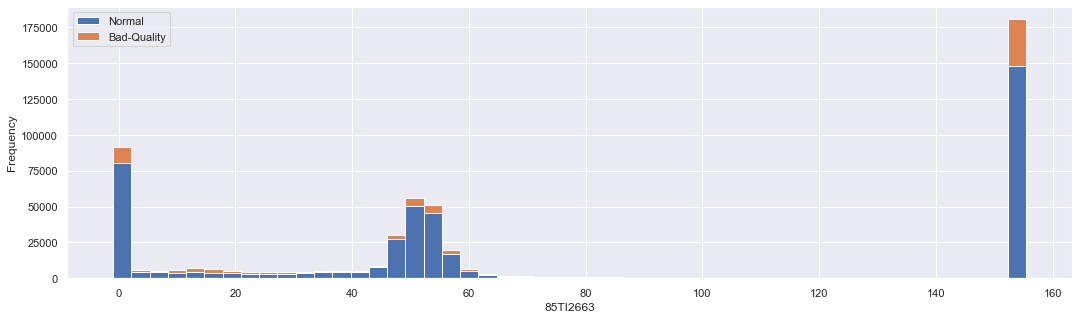

In [70]:
# Individual group distribution
fig, ax = plt.subplots(figsize=(18,5))
plot_distribution(df_target, '85TI2663', target_tag_class=target_tag_class, ax=ax)

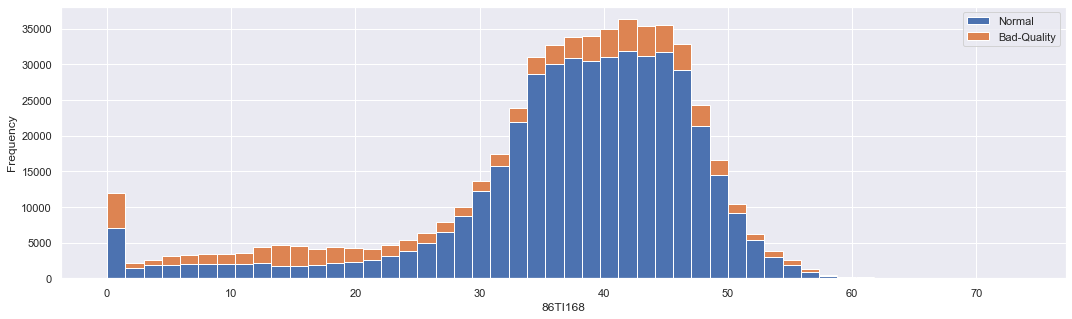

In [66]:
# Individual group distribution
fig, ax = plt.subplots(figsize=(18,5))
plot_distribution(df_target, '86TI168', target_tag_class=target_tag_class, ax=ax)

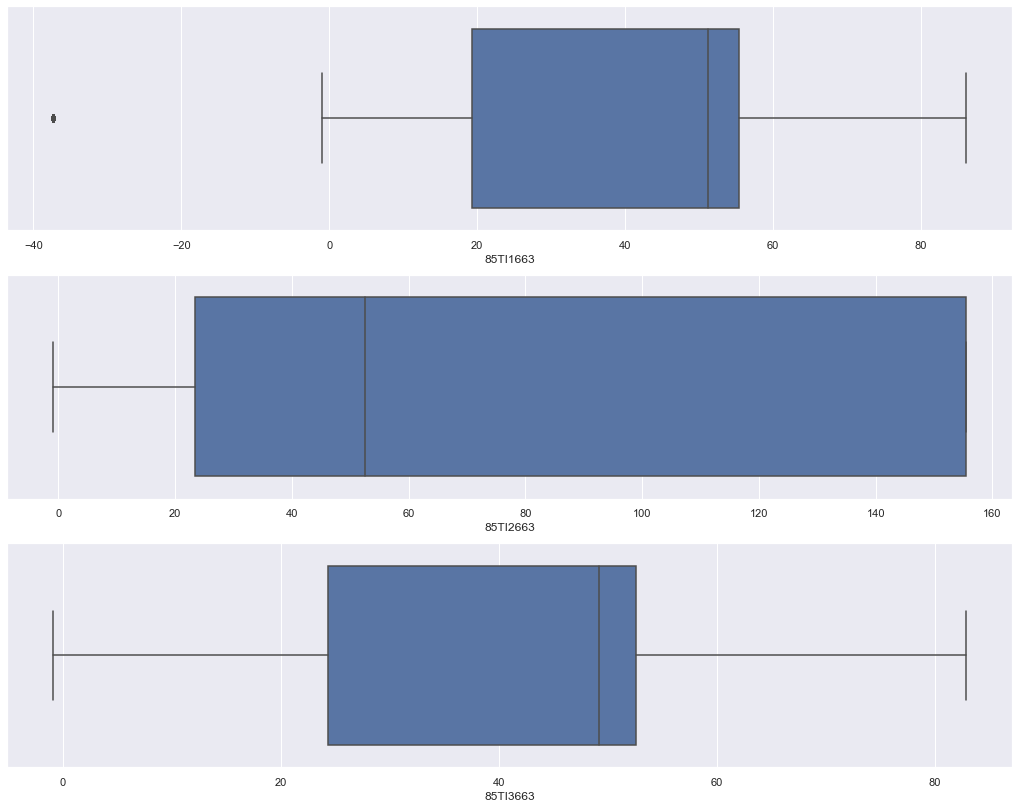

In [69]:
# Plot the statistical distribution if ORE
fig, axs = plt.subplots(nrows=3, figsize=(18,14))

# Plot histogram
sns.boxplot(df_target["85TI1663"], ax=axs[0])
sns.boxplot(df_target["85TI2663"],ax=axs[1])
sns.boxplot(df_target["85TI3663"], ax=axs[2])

# Remove scientific notation
axs[0].ticklabel_format(style='plain', axis='x')
axs[1].ticklabel_format(style='plain', axis='x')
axs[2].ticklabel_format(style='plain', axis='x')
plt.show()

<a id='evaluation'></a>